In [1]:
# Install necessary packages
!pip install ekphrasis
!pip install tweet-preprocessor
!pip install wordcloud
!pip install langdetect
!pip install MarkupSafe==2.0.1 mpmath==0.19 accelerate==0.27.2 sentence-transformers==2.5.1
!pip install config
!pip install chardet
!pip install nltk
!pip install pandas
!pip install bs4
!pip install string


[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1
[notice] To update, run: pip install --upgrade pip



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from collections import Counter
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from dataset_analysis import *

[nltk_data] Downloading package punkt to /Users/gaia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gaia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/gaia/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/gaia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gaia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/gaia/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
# Load the data
data_path = '../dataset/cleaned_events.csv'  
events_df = pd.read_csv(data_path, encoding='ISO-8859-1', encoding_errors='replace')

### Categories

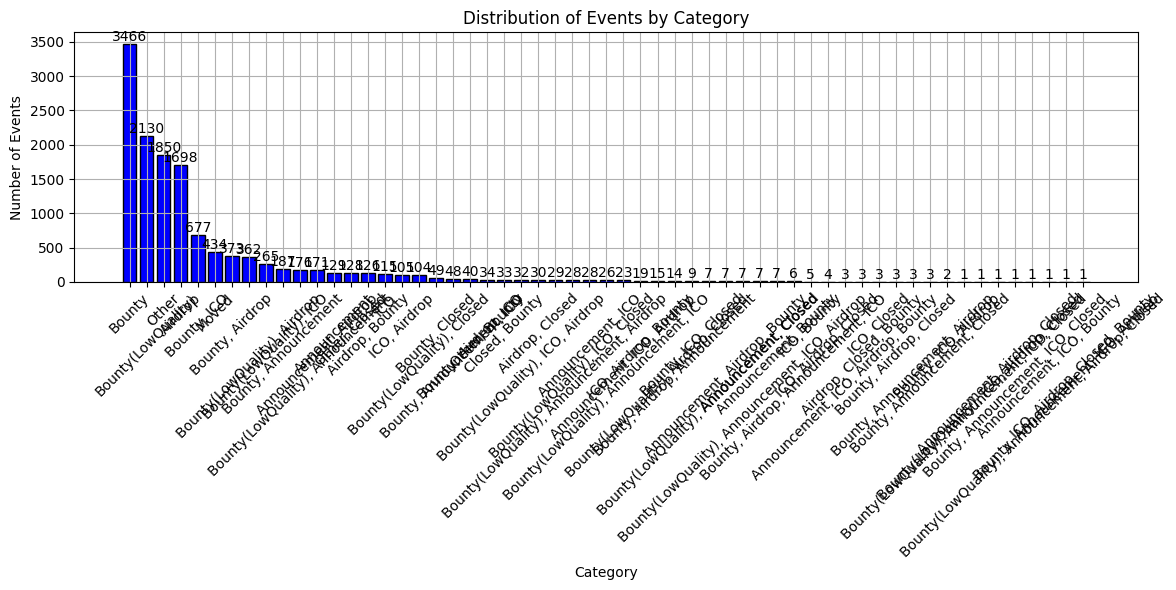

In [5]:
# Ensure 'category' column is treated as string
events_df['categories'] = events_df['categories'].astype(str)

# Count the number of events per category
category_counts = events_df['categories'].value_counts()

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(category_counts.index, category_counts.values, color='blue', edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set titles and labels
plt.title('Distribution of Events by Category')
plt.xlabel('Category')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


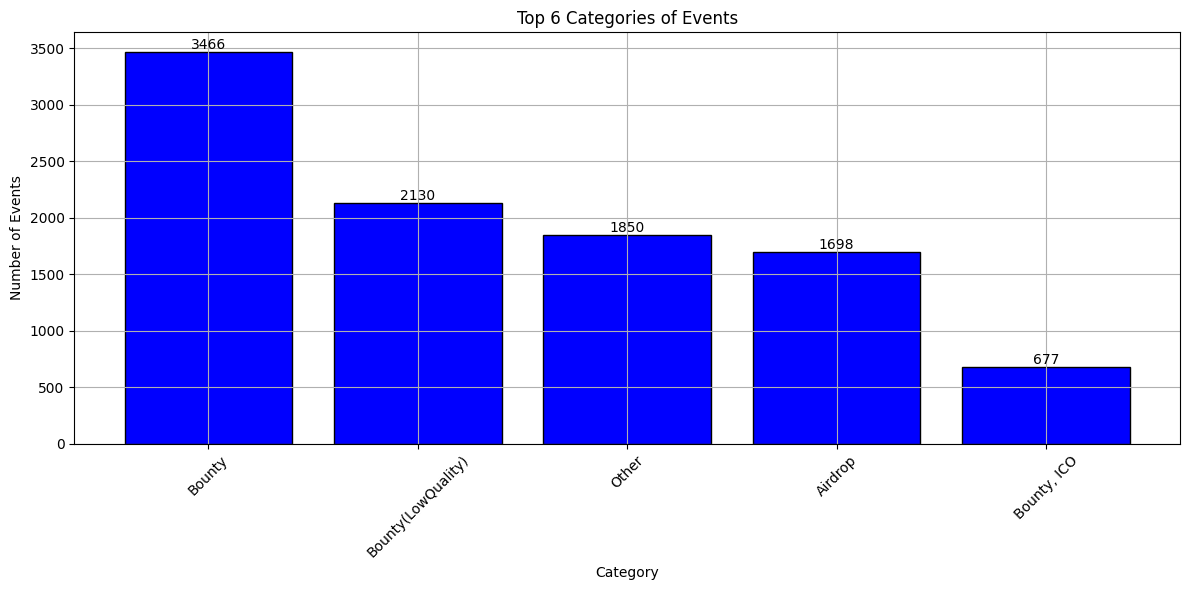

In [6]:
# Filter out events containing the word "closed" or "nan" in the 'categories' column (case insensitive)
filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]

# Count the number of events per category and get the top 5 categories
top_categories = events_df['categories'].value_counts().head(5)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_categories.index, top_categories.values, color='blue', edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set titles and labels
plt.title('Top 6 Categories of Events')
plt.xlabel('Category')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


## Number of consecutive days a bounty event stayed active

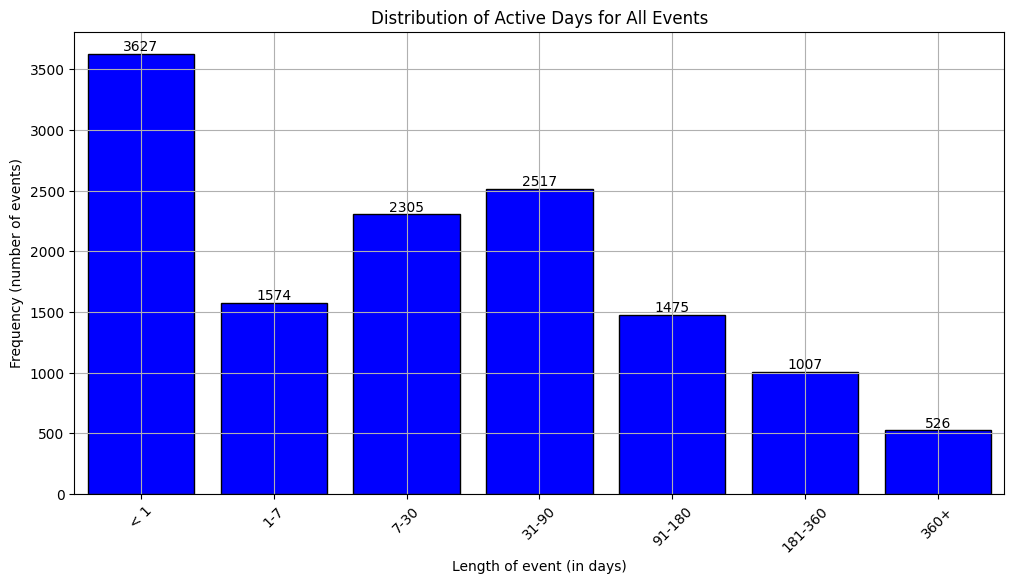

In [7]:
# Ensure relevant columns are treated as strings and dates
events_df['thread_id'] = events_df['thread_id'].astype(str)
events_df['clean_title'] = events_df['clean_title'].astype(str)

# Trim any whitespace in column names
events_df.columns = events_df.columns.str.strip()

# Ensure date columns are parsed correctly
events_df['post_time'] = pd.to_datetime(events_df['post_time'], errors='coerce', dayfirst=True)
events_df['last_post_time'] = pd.to_datetime(events_df['last_post_time'], errors='coerce', dayfirst=True)

# Calculate event duration in days
events_df['active_days'] = (events_df['last_post_time'] - events_df['post_time']).dt.days

# Filter out invalid active days
events_df = events_df.dropna(subset=['active_days'])
events_df = events_df[events_df['active_days'] >= 0]

# Define custom bins and labels
bins = [0, 1, 7, 30, 90, 180, 360, events_df['active_days'].max() + 1]
labels = ['< 1', '1-7', '7-30', '31-90', '91-180', '181-360', '360+']

# Calculate histogram data
hist, bin_edges = np.histogram(events_df['active_days'], bins=bins)

# Define custom bar positions to avoid overlap
bar_positions = np.arange(len(hist))

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(bar_positions, hist, width=0.8, align='center', color='blue', edgecolor='black')

# Add labels on top of the bars
for bar, height in zip(bars, hist):
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set x-tick labels to the custom labels
plt.xticks(bar_positions, labels, rotation=45)

# Set titles and labels
plt.title('Distribution of Active Days for All Events')
plt.xlabel('Length of event (in days)')
plt.ylabel('Frequency (number of events)')
# plt.yscale('log')  # Optional: set y-axis to logarithmic scale if desired
plt.xlim(-0.5, len(bar_positions) - 0.5)  # Adjust x-axis limits to fit bars

# Display the grid and plot
plt.grid(True)
plt.show()


### By Category

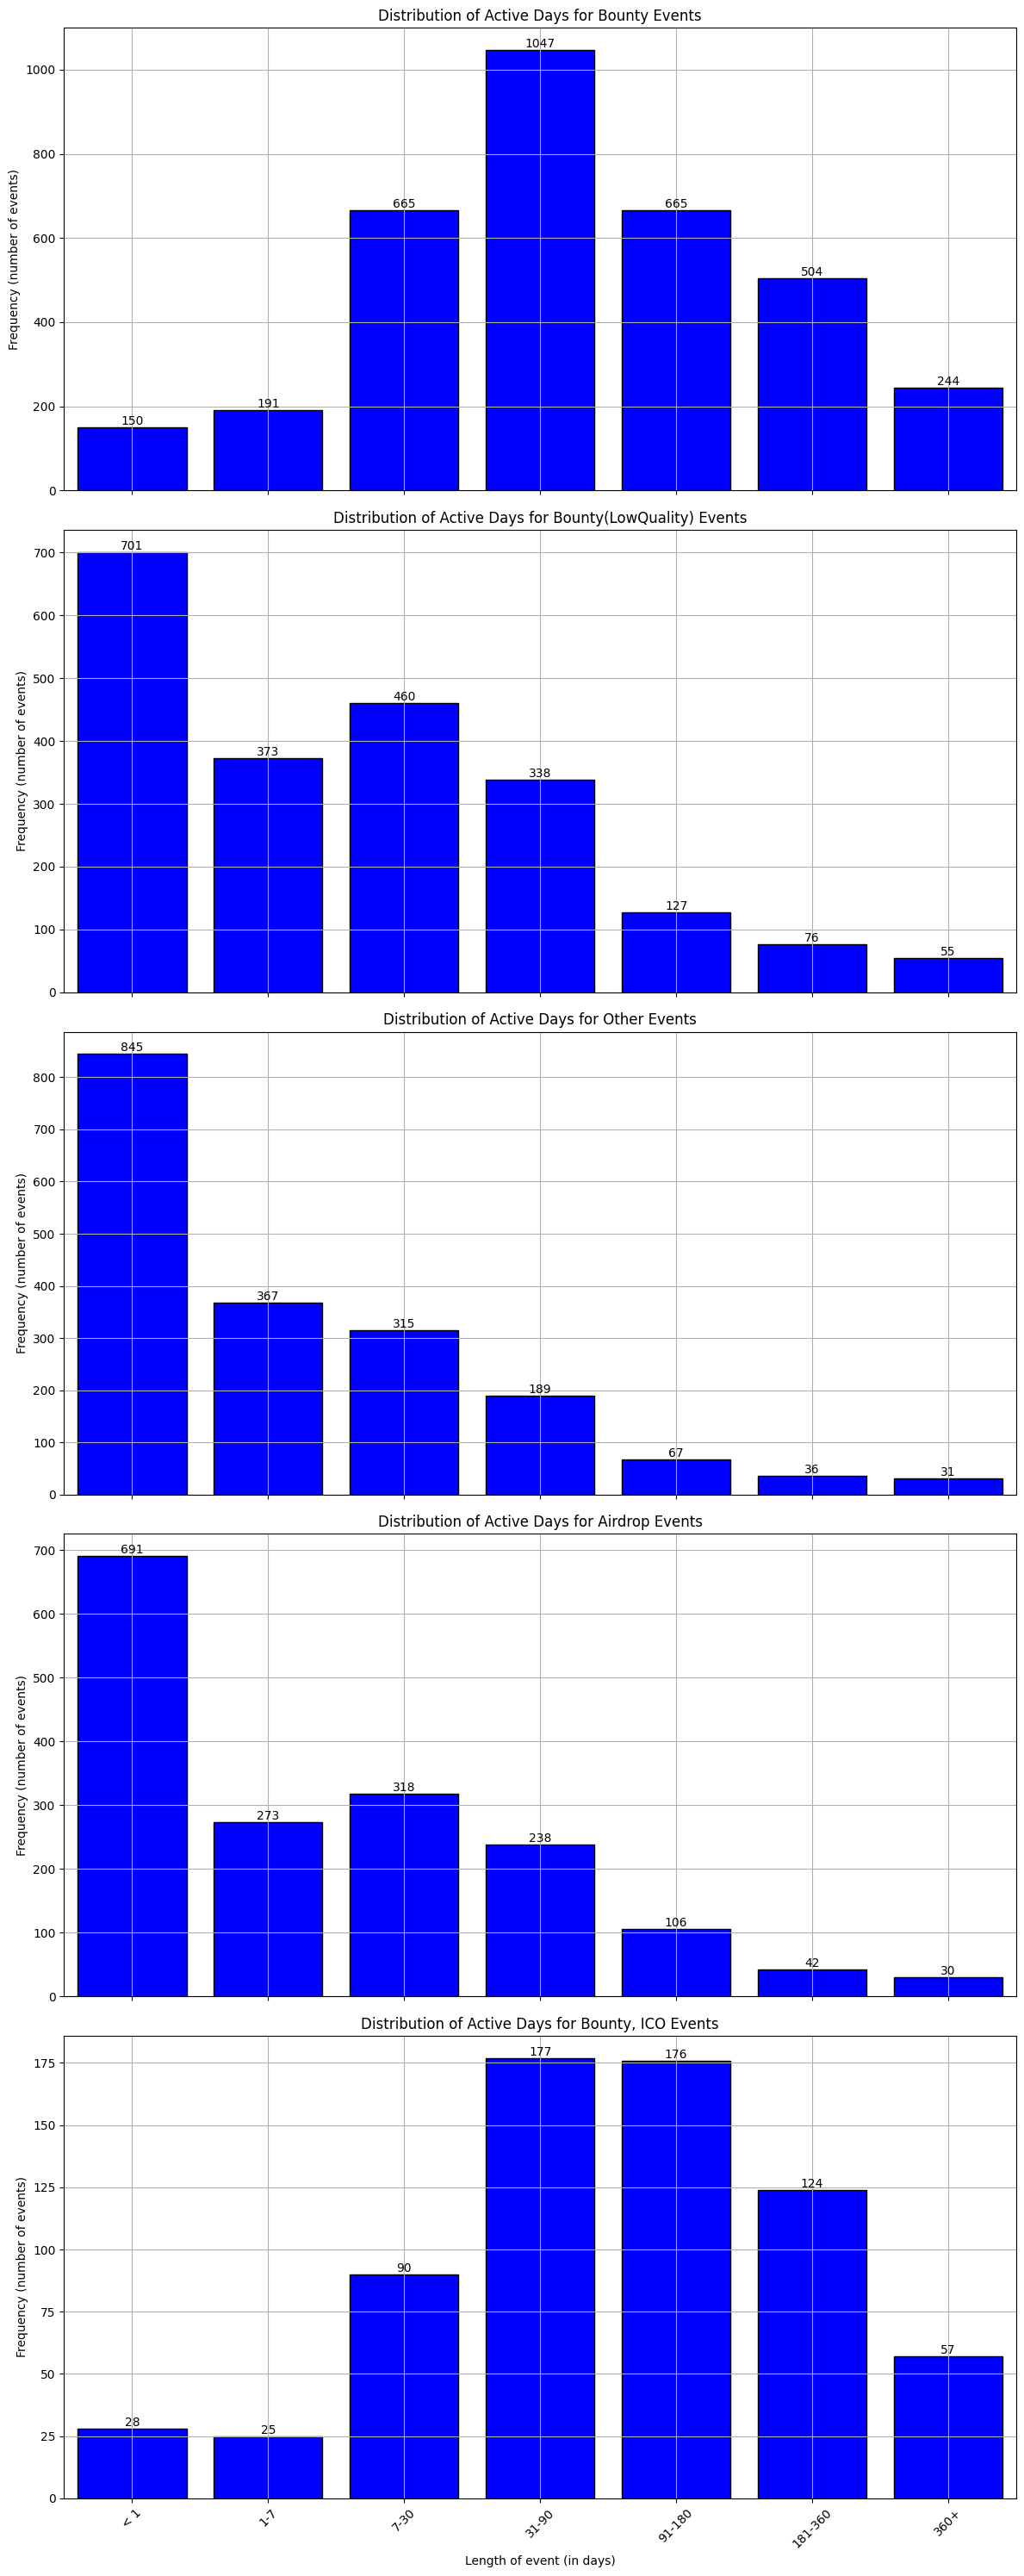

In [8]:
# Calculate event duration in days
events_df['active_days'] = (events_df['last_post_time'] - events_df['post_time']).dt.days

# Filter out invalid active days
events_df = events_df.dropna(subset=['active_days'])
events_df = events_df[events_df['active_days'] >= 0]

# Filter out events containing the word "closed" or "nan" in the 'categories' column (case insensitive)
filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]

# Get top categories
top_categories = filtered_events_df['categories'].value_counts().head(5).index.tolist()

# Create subplots
fig, axes = plt.subplots(len(top_categories), 1, figsize=(12, len(top_categories) * 6), sharex=True)

# Iterate through each category and plot the histogram
for ax, category in zip(axes, top_categories):
    category_df = filtered_events_df[filtered_events_df['categories'] == category]
    hist, bin_edges = np.histogram(category_df['active_days'], bins=bins)
    bar_positions = np.arange(len(hist))

    # Plot the histogram
    bars = ax.bar(bar_positions, hist, width=0.8, align='center', color='blue', edgecolor='black')
    
    # Add labels on top of the bars
    for bar, height in zip(bars, hist):
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')
    
    # Set titles and labels
    ax.set_title(f'Distribution of Active Days for {category} Events')
    ax.set_ylabel('Frequency (number of events)')
    #ax.set_yscale('log')  # Optional: set y-axis to logarithmic scale if desired
    ax.grid(True)

# Set x-tick labels to the custom labels
plt.xticks(bar_positions, labels, rotation=45)
plt.xlabel('Length of event (in days)')
plt.xlim(-0.5, len(bar_positions) - 0.5)  # Adjust x-axis limits to fit bars

# Adjust layout
plt.tight_layout()
plt.show()

## Distribution of Social Media URLs

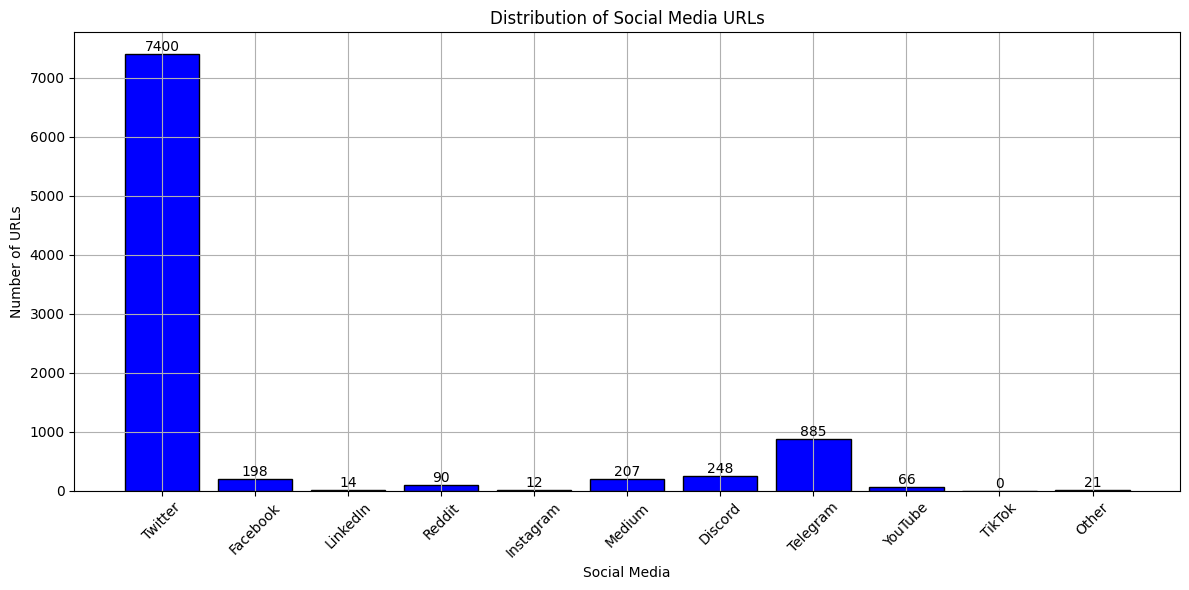

Social Media  Count
0       Twitter   7400
1      Facebook    198
2      LinkedIn     14
3        Reddit     90
4     Instagram     12
5        Medium    207
6       Discord    248
7      Telegram    885
8       YouTube     66
9        TikTok      0
10        Other     21

In [9]:
# Ensure 'social_media_urls' column is treated as string
events_df['social_media_urls'] = events_df['social_media_urls'].astype(str)

# Define the list of social media keywords
social_media_keywords = {
    'Twitter': 'twitter',
    'Facebook': 'facebook',
    'LinkedIn': 'linkedin',
    'Reddit': 'reddit',
    'Instagram': 'instagram',
    'Medium': 'medium',
    'Discord': 'discord',
    'Telegram': 't.me',
    'YouTube': 'youtube',
    'TikTok': 'tiktok'
}

# Initialize a dictionary to store counts
social_media_counts = {key: 0 for key in social_media_keywords}
social_media_counts['Other'] = 0

# Count occurrences of each social media keyword
for urls in events_df['social_media_urls']:
    if urls.lower() == 'nan':
        continue  # Skip NaN values converted to string
    found = False
    for key, keyword in social_media_keywords.items():
        if keyword in urls.lower():
            social_media_counts[key] += 1
            found = True
            break
    if not found:
        social_media_counts['Other'] += 1

# Convert the dictionary to a DataFrame for easier plotting
social_media_counts_df = pd.DataFrame(list(social_media_counts.items()), columns=['Social Media', 'Count'])

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(social_media_counts_df['Social Media'], social_media_counts_df['Count'], color='blue', edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Set titles and labels
plt.title('Distribution of Social Media URLs')
plt.xlabel('Social Media')
plt.ylabel('Number of URLs')
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

social_media_counts_df.head(20)  # Display the counts for verification



### By Category

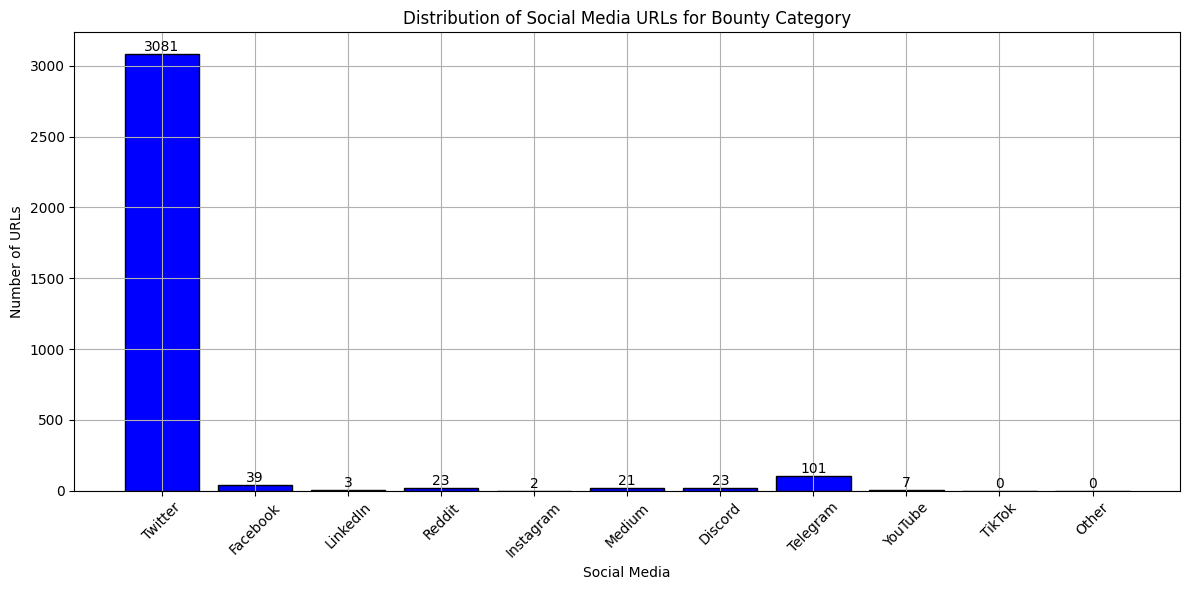

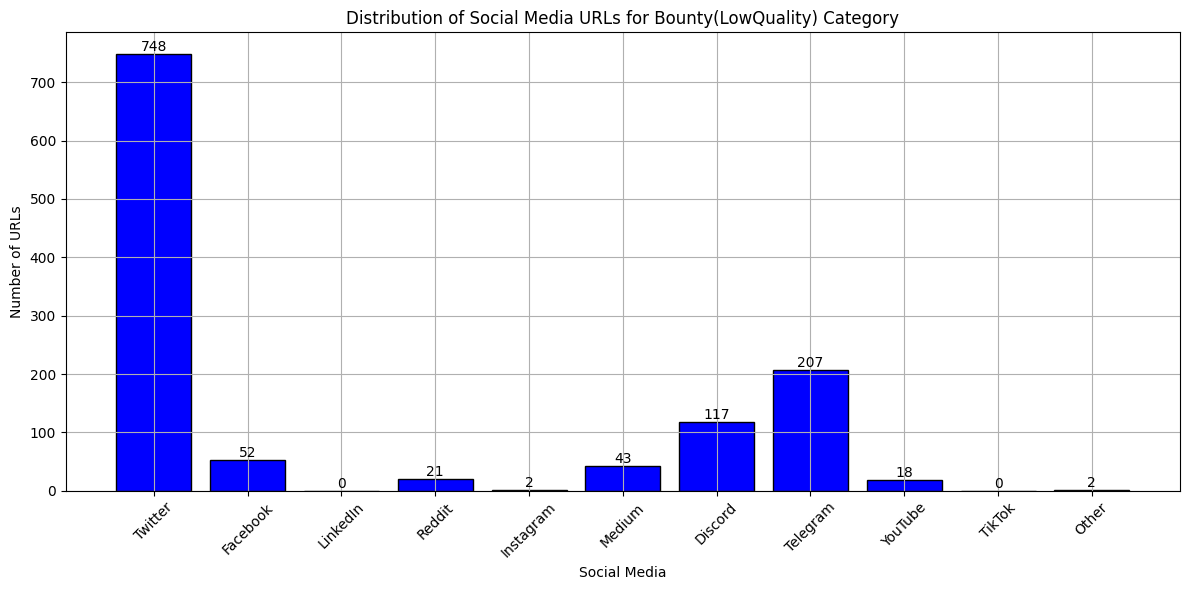

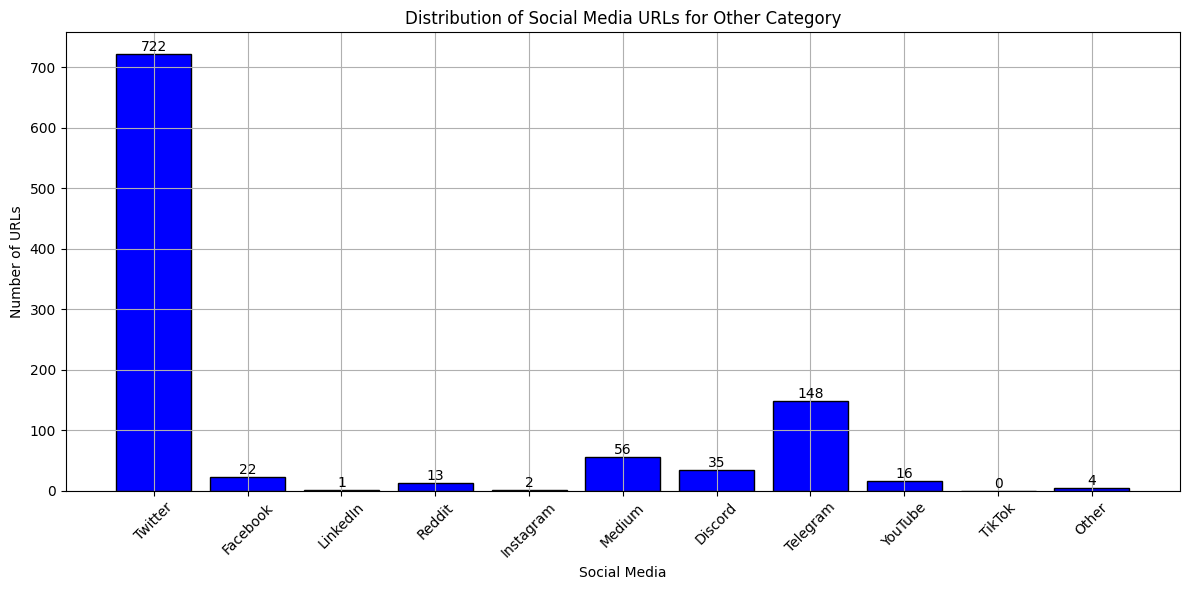

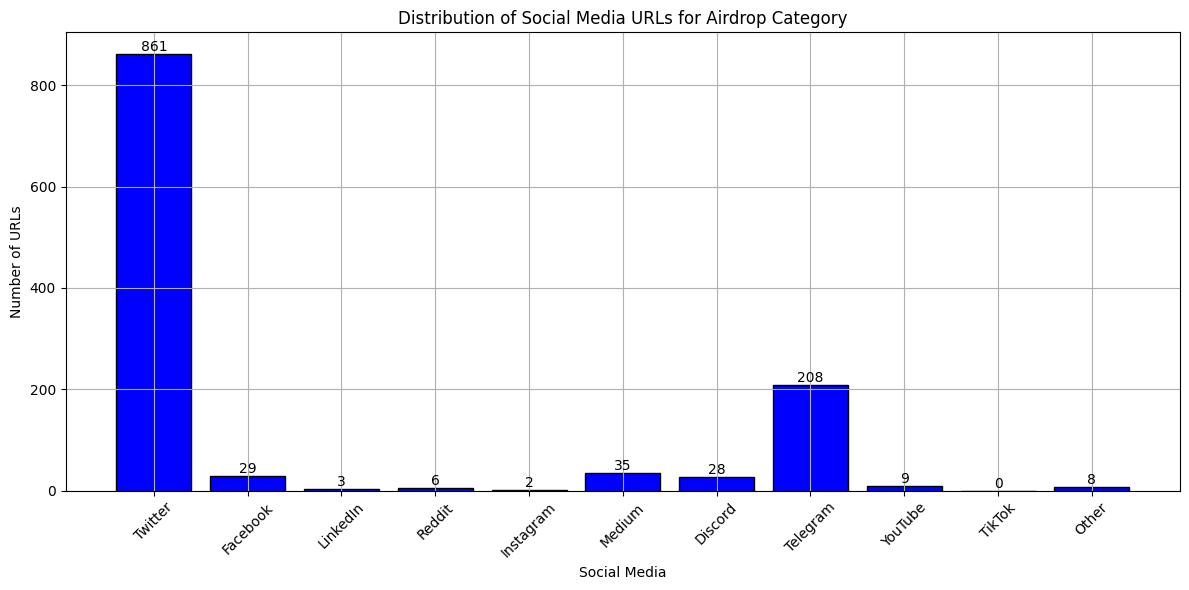

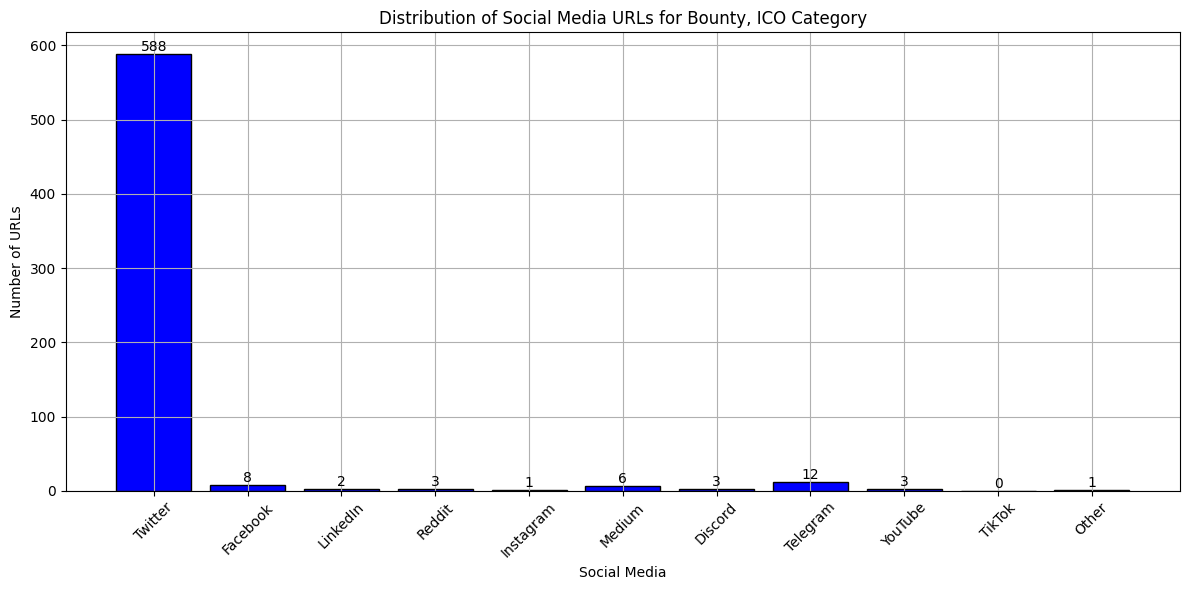

In [10]:
# Filter out events containing the word "closed" or "nan" in the 'categories' column (case insensitive)
filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]

# Count the number of events per category and get the top 5 categories
top_categories = filtered_events_df['categories'].value_counts().head(5).index.tolist()

# Initialize a dictionary to store counts for each category
category_social_media_counts = {category: {key: 0 for key in social_media_keywords} for category in top_categories}
for category in top_categories:
    category_social_media_counts[category]['Other'] = 0

# Count occurrences of each social media keyword for the top categories
for category in top_categories:
    category_df = filtered_events_df[filtered_events_df['categories'] == category]
    for urls in category_df['social_media_urls']:
        if urls.lower() == 'nan':
            continue  # Skip NaN values converted to string
        found = False
        for key, keyword in social_media_keywords.items():
            if keyword in urls.lower():
                category_social_media_counts[category][key] += 1
                found = True
                break
        if not found:
            category_social_media_counts[category]['Other'] += 1

# Plot the distribution for each top category
for category in top_categories:
    counts_df = pd.DataFrame(list(category_social_media_counts[category].items()), columns=['Social Media', 'Count'])
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(counts_df['Social Media'], counts_df['Count'], color='blue', edgecolor='black')

    # Add labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

    # Set titles and labels
    plt.title(f'Distribution of Social Media URLs for {category} Category')
    plt.xlabel('Social Media')
    plt.ylabel('Number of URLs')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


## Distribution of Reward Allocation Shares

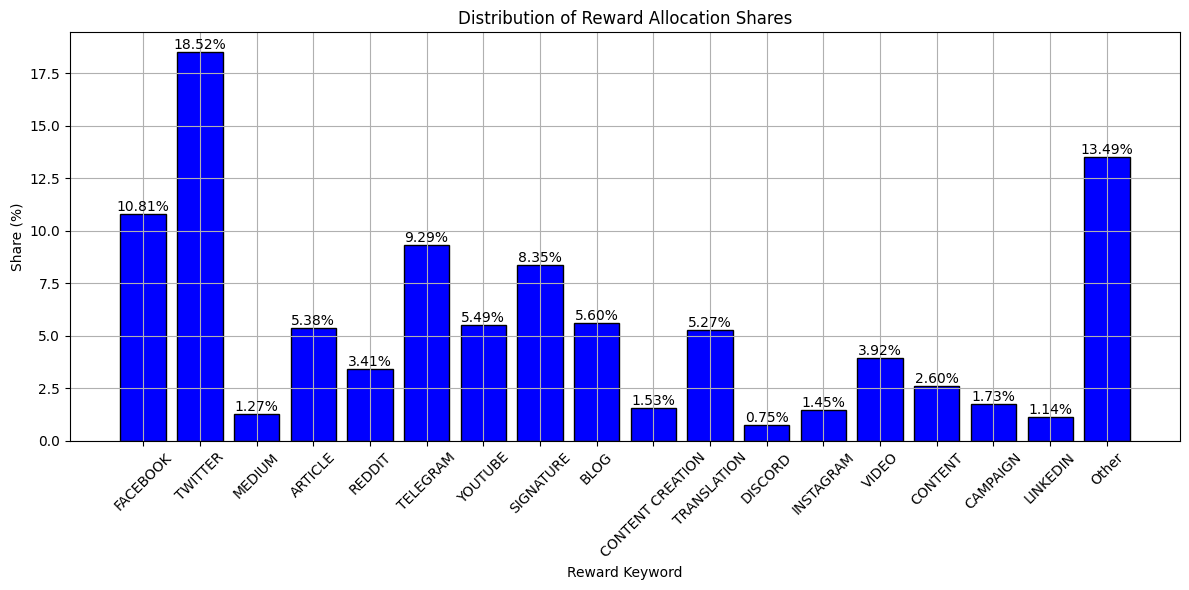

      Reward Keyword      Share
0           FACEBOOK  10.813745
1            TWITTER  18.516624
2             MEDIUM   1.267831
3            ARTICLE   5.375952
4             REDDIT   3.409997
5           TELEGRAM   9.291218
6            YOUTUBE   5.489557
7          SIGNATURE   8.349545
8               BLOG   5.595681
9   CONTENT CREATION   1.533521
10       TRANSLATION   5.266469
11           DISCORD   0.753400
12         INSTAGRAM   1.450608
13             VIDEO   3.924886
14           CONTENT   2.600252
15          CAMPAIGN   1.728819
16          LINKEDIN   1.141705
17             Other  13.490192
Keywords in 'Other' category:
{'SHILL', 'JOIN', 'NETWORK', 'SUBSCRIBE', 'MULTIMEDIA', 'ALTCOINSTALKS', 'CREATORS', 'FOR', 'OFFLINE', 'NFTS', 'MEETUP', 'RESERVE', 'PUBLISHING', 'CAMPAIGNS', 'SELFIE', 'OFFER', 'NEWS', 'POST', 'SUBSCRIPTION', 'SHORT', 'WEBSITE', 'GOLOS', 'FEEDBACK', 'ART', 'BANNER', 'GRAPHICS', 'MODERATION', 'BITCOINTALK', 'KOL', 'PUBLICATION', 'REGISTRATION', 'TIKTOK', 'WRIT

In [11]:
# Ensure 'reward_allocation' column is treated as string
events_df['reward_allocation'] = events_df['reward_allocation'].astype(str)

# Define the list of reward allocation keywords
reward_keywords = [
    'FACEBOOK', 'TWITTER', 'MEDIUM', 'ARTICLE', 'REDDIT', 
    'TELEGRAM', 'YOUTUBE', 'SIGNATURE', 'BLOG', 'CONTENT CREATION', 
    'TRANSLATION', 'DISCORD', 'INSTAGRAM', 'VIDEO', 
    'CONTENT', 'CAMPAIGN',  'LINKEDIN'
]

# Initialize a dictionary to store the summed percentages for each keyword
reward_allocation_sums = {key: 0 for key in reward_keywords}
reward_allocation_sums['Other'] = 0

# Initialize a list to store other keywords and their occurrences
other_keywords_list = []

# Define a function to extract percentages from the text
def extract_percentage(text):
    matches = re.findall(r'(\d+)%', text)
    return [int(match) for match in matches]

# Count occurrences of each reward keyword and sum their percentages
for allocation in events_df['reward_allocation']:
    # Extract percentages from the allocation string
    percentages = extract_percentage(allocation)
    
    found_keywords = set()
    for keyword in reward_keywords:
        if keyword in allocation:
            found_keywords.add(keyword)
            # Find all instances of the keyword
            keyword_matches = re.findall(rf'{keyword}', allocation)
            
            # Sum percentages if the keyword is followed by a percentage
            for match in keyword_matches:
                # Check if the keyword is followed by a percentage
                index = allocation.find(match) + len(match)
                if index < len(allocation):
                    match_percentages = re.findall(r'(\d+)%', allocation[index:])
                    for percent in match_percentages:
                        reward_allocation_sums[keyword] += int(percent)
    
    # Handle the 'Other' category
    other_text = re.sub(r'(\d+)%', '', allocation)
    other_keywords = set(re.findall(r'\b[A-Z]+\b', other_text))
    other_keywords = other_keywords - set(reward_keywords)
    
    for keyword in other_keywords:
        other_keywords_list.append(keyword)
        reward_allocation_sums['Other'] += 1 / len(other_keywords) * sum(percentages)

# Calculate the total percentage
total_percentage = sum(reward_allocation_sums.values())

# Calculate the share of each keyword
reward_allocation_share = {key: (value / total_percentage) * 100 for key, value in reward_allocation_sums.items()}

# Convert the dictionary to a DataFrame for easier plotting
reward_allocation_share_df = pd.DataFrame(list(reward_allocation_share.items()), columns=['Reward Keyword', 'Share'])

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reward_allocation_share_df['Reward Keyword'], reward_allocation_share_df['Share'], color='blue', edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

# Set titles and labels
plt.title('Distribution of Reward Allocation Shares')
plt.xlabel('Reward Keyword')
plt.ylabel('Share (%)')
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the counts for verification
print(reward_allocation_share_df)

# Display the unique keywords in 'Other' category
unique_other_keywords = set(other_keywords_list)
print("Keywords in 'Other' category:")
print(unique_other_keywords)

# Find the keyword with the biggest share in 'Other'
from collections import Counter
other_keyword_counts = Counter(other_keywords_list)
most_common_other = other_keyword_counts.most_common(1)
print("Most common keyword in 'Other' category and its count:")
print(most_common_other)


### By Category

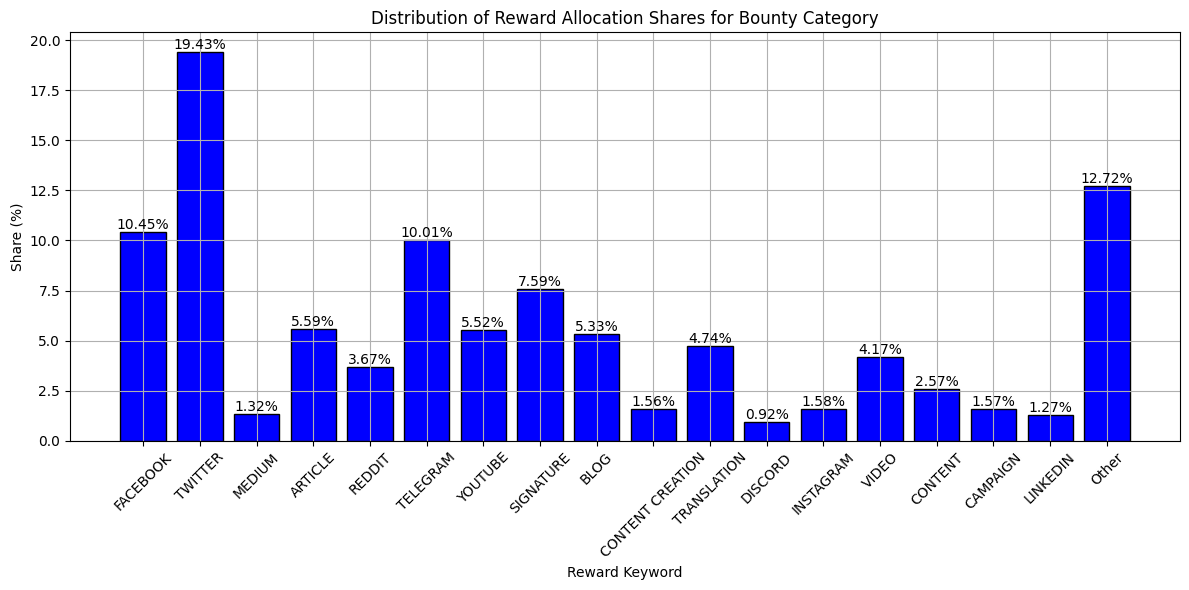

Keywords in 'Other' category for Bounty category:
{'SHILL', 'JOIN', 'NETWORK', 'SUBSCRIBE', 'MULTIMEDIA', 'ALTCOINSTALKS', 'CREATORS', 'FOR', 'NFTS', 'RESERVE', 'CAMPAIGNS', 'SELFIE', 'OFFER', 'NEWS', 'POST', 'SUBSCRIPTION', 'SHORT', 'WEBSITE', 'GOLOS', 'FEEDBACK', 'ART', 'GRAPHICS', 'MODERATION', 'BITCOINTALK', 'KOL', 'PUBLICATION', 'REGISTRATION', 'TIKTOK', 'WRITING', 'TWITCH', 'SIGN', 'TESTERS', 'VK', 'SLACK', 'GROUP', 'ICO', 'DESIGN', 'DOWNLOAD', 'CRYPTOCOMPARE', 'DOCUMENTS', 'VFX', 'GIF', 'PROGRAM', 'EXTRA', 'SPECIAL', 'DAILY', 'AUTO', 'TOP', 'MANAGMENT', 'SIGNUP', 'COINGECKO', 'RAFFLE', 'APP', 'US', 'BOUTNY', 'REFERRAL', 'CONTEST', 'OWNERSHIP', 'SUPPORT', 'MANAGEMENT', 'CREATIVE', 'INVITE', 'MISCELLANEOUS', 'FUND', 'HOLDER', 'DEVELOPMENT', 'HUNT', 'UP', 'TOKEN', 'COMMUNITY', 'VKONTAKTE', 'AUDIT', 'AVATAR', 'HACKING', 'QUIZ', 'CREATION', 'EXCLUSIVE', 'MISC', 'NEWSLETTER', 'AIRDROP', 'INVESTORS', 'HAHALOLO', 'TEXT', 'COPY', 'FORUM', 'STEEMIT', 'TASKS', 'BONUS', 'MEMES', 'ARTWORK', 

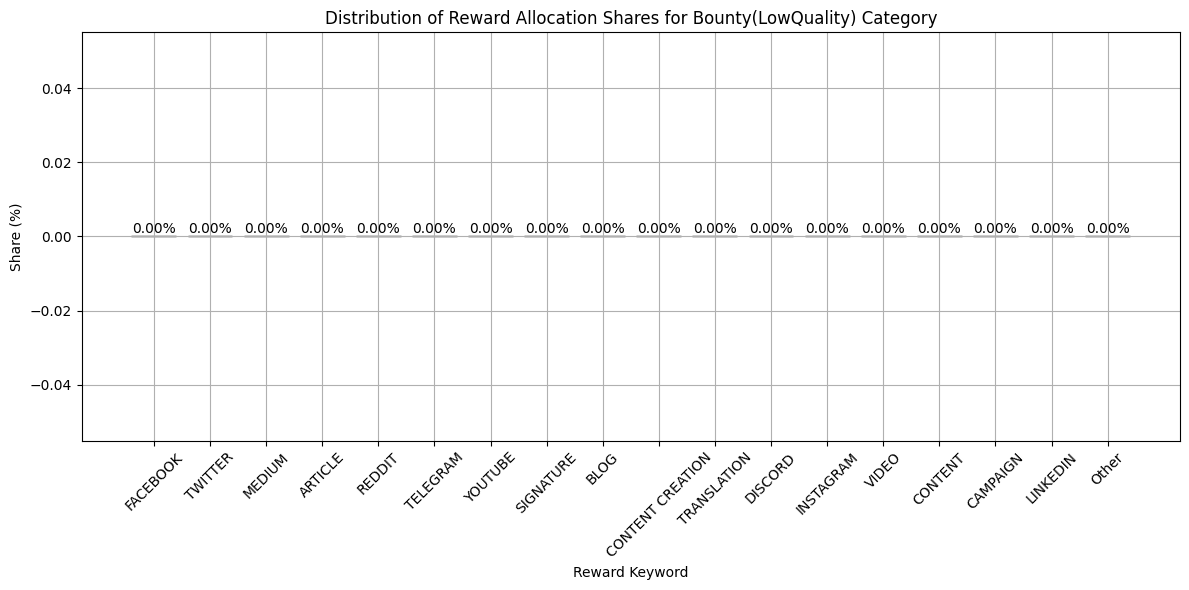

Keywords in 'Other' category for Bounty(LowQuality) category:
set()
Most common keyword in 'Other' category for Bounty(LowQuality) category and its count:
[]


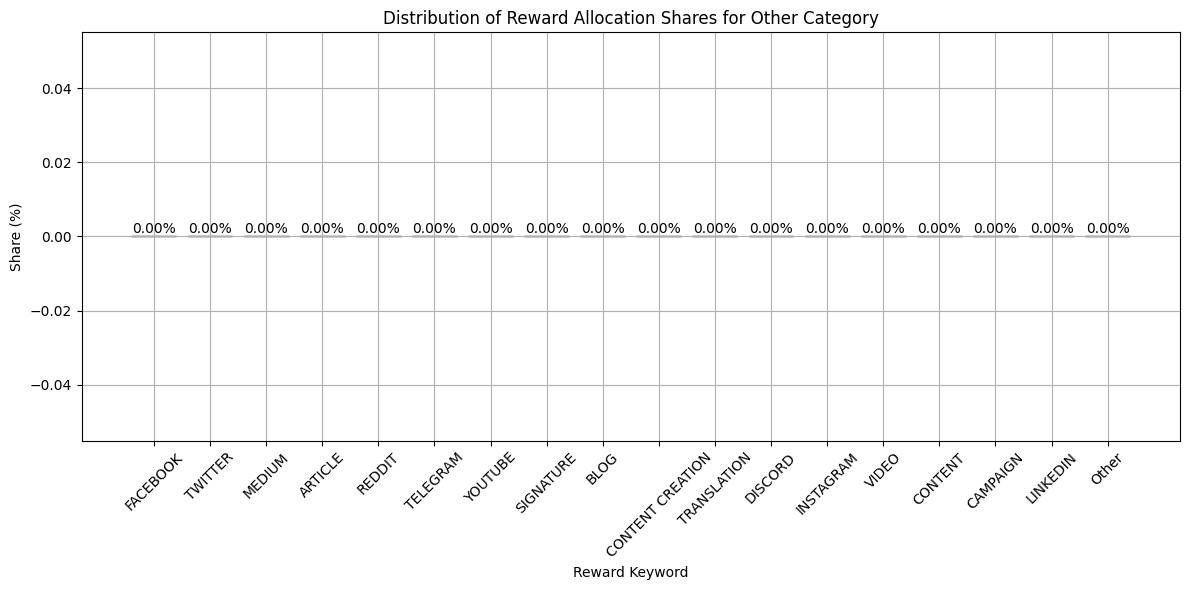

Keywords in 'Other' category for Other category:
set()
Most common keyword in 'Other' category for Other category and its count:
[]


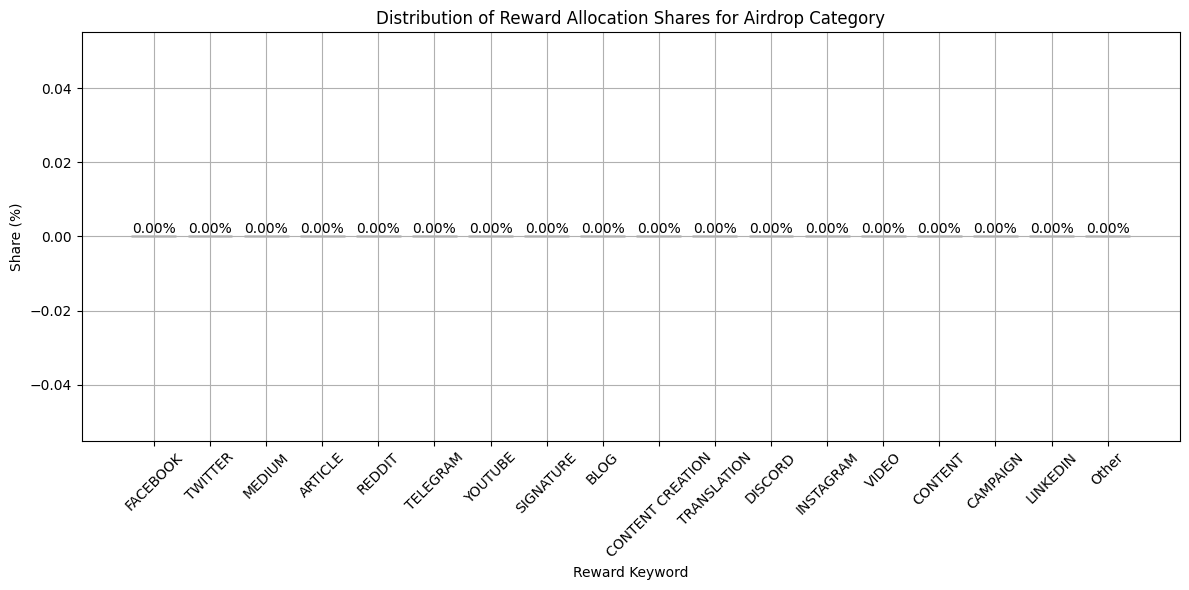

Keywords in 'Other' category for Airdrop category:
set()
Most common keyword in 'Other' category for Airdrop category and its count:
[]


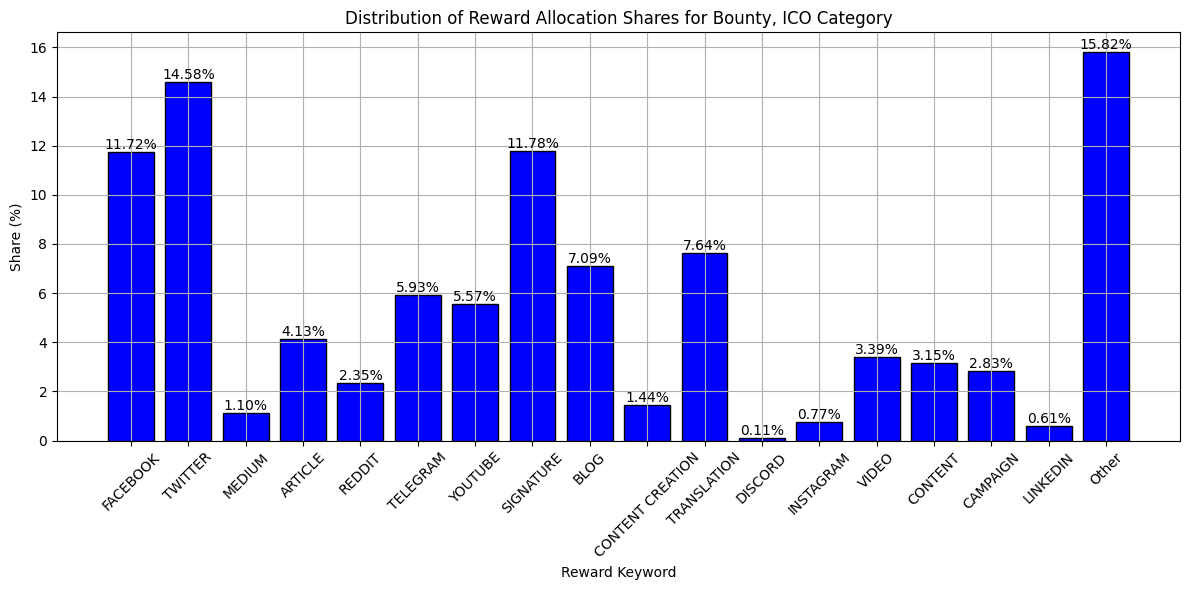

Keywords in 'Other' category for Bounty, ICO category:
{'INFLUENCERS', 'ICO', 'DESIGN', 'DOWNLOAD', 'JOIN', 'REVIEW', 'DOCUMENTS', 'CREATION', 'EVANGELISTS', 'NETWORK', 'VK', 'FOLLOW', 'OF', 'SUBSCRIBE', 'PROGRAM', 'EXTRA', 'EXCLUSIVE', 'SPECIAL', 'MISC', 'NEWSLETTER', 'AIRDROP', 'RESERVE', 'APP', 'SLACK', 'STEEMIT', 'GROUP', 'POST', 'REFERRAL', 'WHITEPAPER', 'BONUS', 'SUBSCRIPTION', 'OWNERSHIP', 'CONTEST', 'NEWS', 'SUPPORT', 'BUG', 'MANAGEMENT', 'BTT', 'ARTWORK', 'CREATIVE', 'BANNER', 'ENGAGEMENT', 'MISCELLANEOUS', 'AND', 'FUND', 'GRAPHICS', 'TRANSLATORS', 'MODERATION', 'DEVELOPMENT', 'SOCIAL', 'BITCOINTALK', 'AMBASSADOR', 'PUBLICATION', 'SEARCH', 'BOUNTY', 'TIKTOK', 'MEDIA', 'HUNT', 'COMMUNITY', 'VKONTAKTE', 'STEEM', 'OTHER', 'AVATAR'}
Most common keyword in 'Other' category for Bounty, ICO category and its count:
[('BITCOINTALK', 31)]


In [12]:
# Filter out events containing the word "closed" or "nan" in the 'categories' column (case insensitive)
filtered_events_df = events_df[~events_df['categories'].str.contains('closed|nan', case=False, na=False)]

# Count the number of events per category and get the top 5 categories
top_categories = filtered_events_df['categories'].value_counts().head(5).index.tolist()

# Initialize a dictionary to store the summed percentages for each keyword for each category
category_reward_allocation_sums = {category: {key: 0 for key in reward_keywords} for category in top_categories}
for category in top_categories:
    category_reward_allocation_sums[category]['Other'] = 0

# Initialize a dictionary to store other keywords for each category
category_other_keywords = {category: [] for category in top_categories}

# Define a function to extract percentages from the text
def extract_percentage(text):
    matches = re.findall(r'(\d+)%', text)
    return [int(match) for match in matches]

# Count occurrences of each reward keyword and sum their percentages for the top categories
for category in top_categories:
    category_df = filtered_events_df[filtered_events_df['categories'] == category]
    for allocation in category_df['reward_allocation']:
        # Extract percentages from the allocation string
        percentages = extract_percentage(allocation)
        
        found_keywords = set()
        for keyword in reward_keywords:
            if keyword in allocation:
                found_keywords.add(keyword)
                # Find all instances of the keyword
                keyword_matches = re.findall(rf'{keyword}', allocation)
                
                # Sum percentages if the keyword is followed by a percentage
                for match in keyword_matches:
                    # Check if the keyword is followed by a percentage
                    index = allocation.find(match) + len(match)
                    if index < len(allocation):
                        match_percentages = re.findall(r'(\d+)%', allocation[index:])
                        for percent in match_percentages:
                            category_reward_allocation_sums[category][keyword] += int(percent)
        
        # Handle the 'Other' category
        other_text = re.sub(r'(\d+)%', '', allocation)
        other_keywords = set(re.findall(r'\b[A-Z]+\b', other_text))
        other_keywords = other_keywords - set(reward_keywords)
        
        for keyword in other_keywords:
            category_other_keywords[category].append(keyword)
            category_reward_allocation_sums[category]['Other'] += 1 / len(other_keywords) * sum(percentages)

# Calculate the share of each keyword for each category
category_reward_allocation_share = {category: {} for category in top_categories}
for category in top_categories:
    total_percentage = sum(category_reward_allocation_sums[category].values())
    if total_percentage > 0:
        category_reward_allocation_share[category] = {key: (value / total_percentage) * 100 for key, value in category_reward_allocation_sums[category].items()}
    else:
        category_reward_allocation_share[category] = {key: 0 for key in category_reward_allocation_sums[category].keys()}

# Plot the distribution for each top category
for category in top_categories:
    share_df = pd.DataFrame(list(category_reward_allocation_share[category].items()), columns=['Reward Keyword', 'Share'])
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(share_df['Reward Keyword'], share_df['Share'], color='blue', edgecolor='black')

    # Add labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

    # Set titles and labels
    plt.title(f'Distribution of Reward Allocation Shares for {category} Category')
    plt.xlabel('Reward Keyword')
    plt.ylabel('Share (%)')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()
    
    # Display the unique keywords in 'Other' category for this category
    unique_other_keywords = set(category_other_keywords[category])
    print(f"Keywords in 'Other' category for {category} category:")
    print(unique_other_keywords)
    
    # Find the keyword with the biggest share in 'Other' for this category
    other_keyword_counts = Counter(category_other_keywords[category])
    most_common_other = other_keyword_counts.most_common(1)
    print(f"Most common keyword in 'Other' category for {category} category and its count:")
    print(most_common_other)


# Find Common Combinations

In [13]:
# Ensure columns are treated as string
events_df['clean_title'] = events_df['clean_title'].astype(str)
events_df['general_rules'] = events_df['general_rules'].astype(str)
events_df['post_tex'] = events_df['post_tex'].astype(str)

# Define a function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'<#NewLine>', ' ', text)  # Remove <#NewLine> tags
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english') and word in english_words]  # Remove stop words and non-English words
    return tokens

# Define a set of English words for filtering
english_words = set(words.words())

# Apply preprocessing separately
events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
events_df['general_rules_tokens'] = events_df['general_rules'].apply(preprocess_text)
events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# Remove rows where the preprocessed text columns are empty
events_df = events_df[events_df['clean_title_tokens'].str.strip() != '']
events_df = events_df[events_df['general_rules_tokens'].str.strip() != '']
events_df = events_df[events_df['post_tex_tokens'].str.strip() != '']


# Flatten the list of tokens and count frequencies for clean_title
all_clean_title_tokens = [token for sublist in events_df['clean_title_tokens'] for token in sublist]
clean_title_word_freq = Counter(all_clean_title_tokens)

# Get the most common words in clean_title
most_common_clean_title_words = clean_title_word_freq.most_common(20)  # Get top 20 most common words
print("Most Common Words in clean_title:")
print(most_common_clean_title_words)

# Flatten the list of tokens and count frequencies for general_rules
all_general_rules_tokens = [token for sublist in events_df['general_rules_tokens'] for token in sublist]
general_rules_word_freq = Counter(all_general_rules_tokens)

# Get the most common words in general_rules
most_common_general_rules_words = general_rules_word_freq.most_common(20)  # Get top 20 most common words
print("Most Common Words in general_rules:")
print(most_common_general_rules_words)

# Flatten the list of tokens and count frequencies for post_tex
all_post_tex_tokens = [token for sublist in events_df['post_tex_tokens'] for token in sublist]
post_tex_word_freq = Counter(all_post_tex_tokens)

# Get the most common words in post_tex
most_common_post_tex_words = post_tex_word_freq.most_common(20)  # Get top 20 most common words
print("Most Common Words in post_tex:")
print(most_common_post_tex_words)

# Find bigrams and trigrams for clean_title
all_clean_title_bigrams = [bigram for sublist in events_df['clean_title_tokens'] for bigram in bigrams(sublist)]
all_clean_title_trigrams = [trigram for sublist in events_df['clean_title_tokens'] for trigram in trigrams(sublist)]

# Count frequencies of bigrams and trigrams for clean_title
clean_title_bigram_freq = Counter(all_clean_title_bigrams)
clean_title_trigram_freq = Counter(all_clean_title_trigrams)

# Get the most common bigrams and trigrams in clean_title
most_common_clean_title_bigrams = clean_title_bigram_freq.most_common(20)  # Get top 20 most common bigrams
most_common_clean_title_trigrams = clean_title_trigram_freq.most_common(20)  # Get top 20 most common trigrams

print("Most Common Bigrams in title:")
print(most_common_clean_title_bigrams)
print("Most Common Trigrams in title:")
print(most_common_clean_title_trigrams)


# Find bigrams and trigrams for general_rules
all_general_rules_bigrams = [bigram for sublist in events_df['general_rules_tokens'] for bigram in bigrams(sublist)]
all_general_rules_trigrams = [trigram for sublist in events_df['general_rules_tokens'] for trigram in trigrams(sublist)]

# Count frequencies of bigrams and trigrams for general_rules
general_rules_bigram_freq = Counter(all_general_rules_bigrams)
general_rules_trigram_freq = Counter(all_general_rules_trigrams)

# Get the most common bigrams and trigrams in general_rules
most_common_general_rules_bigrams = general_rules_bigram_freq.most_common(20)  # Get top 20 most common bigrams
most_common_general_rules_trigrams = general_rules_trigram_freq.most_common(20)  # Get top 20 most common trigrams

print("Most Common Bigrams in general_rules:")
print(most_common_general_rules_bigrams)
print("Most Common Trigrams in general_rules:")
print(most_common_general_rules_trigrams)

# Find bigrams and trigrams for post_tex
all_post_tex_bigrams = [bigram for sublist in events_df['post_tex_tokens'] for bigram in bigrams(sublist)]
all_post_tex_trigrams = [trigram for sublist in events_df['post_tex_tokens'] for trigram in trigrams(sublist)]

# Count frequencies of bigrams and trigrams for post_tex
post_tex_bigram_freq = Counter(all_post_tex_bigrams)
post_tex_trigram_freq = Counter(all_post_tex_trigrams)

# Get the most common bigrams and trigrams in post_tex
most_common_post_tex_bigrams = post_tex_bigram_freq.most_common(20)  # Get top 20 most common bigrams
most_common_post_tex_trigrams = post_tex_trigram_freq.most_common(20)  # Get top 20 most common trigrams

print("Most Common Bigrams in post_tex:")
print(most_common_post_tex_bigrams)
print("Most Common Trigrams in post_tex:")
print(most_common_post_tex_trigrams)




Most Common Words in clean_title:
[('bounty', 2845), ('airdrop', 1525), ('campaign', 1245), ('token', 1060), ('platform', 613), ('reward', 605), ('coin', 568), ('exchange', 524), ('free', 522), ('program', 494), ('get', 475), ('worth', 474), ('pool', 454), ('earn', 443), ('k', 430), ('first', 367), ('twitter', 360), ('new', 355), ('telegram', 347), ('network', 327)]
Most Common Words in general_rules:
[('nan', 10673), ('bounty', 7021), ('campaign', 5776), ('must', 3836), ('telegram', 2384), ('week', 2370), ('post', 2092), ('join', 2022), ('group', 1819), ('thread', 1467), ('right', 1324), ('least', 1307), ('twitter', 1303), ('per', 1296), ('form', 1271), ('please', 1224), ('video', 1191), ('end', 1183), ('account', 1109), ('make', 1087)]
Most Common Words in post_tex:
[('bounty', 56356), ('must', 50644), ('campaign', 38157), ('per', 34047), ('telegram', 31584), ('post', 27343), ('twitter', 23548), ('week', 21157), ('least', 20909), ('link', 19029), ('join', 18480), ('official', 16039),

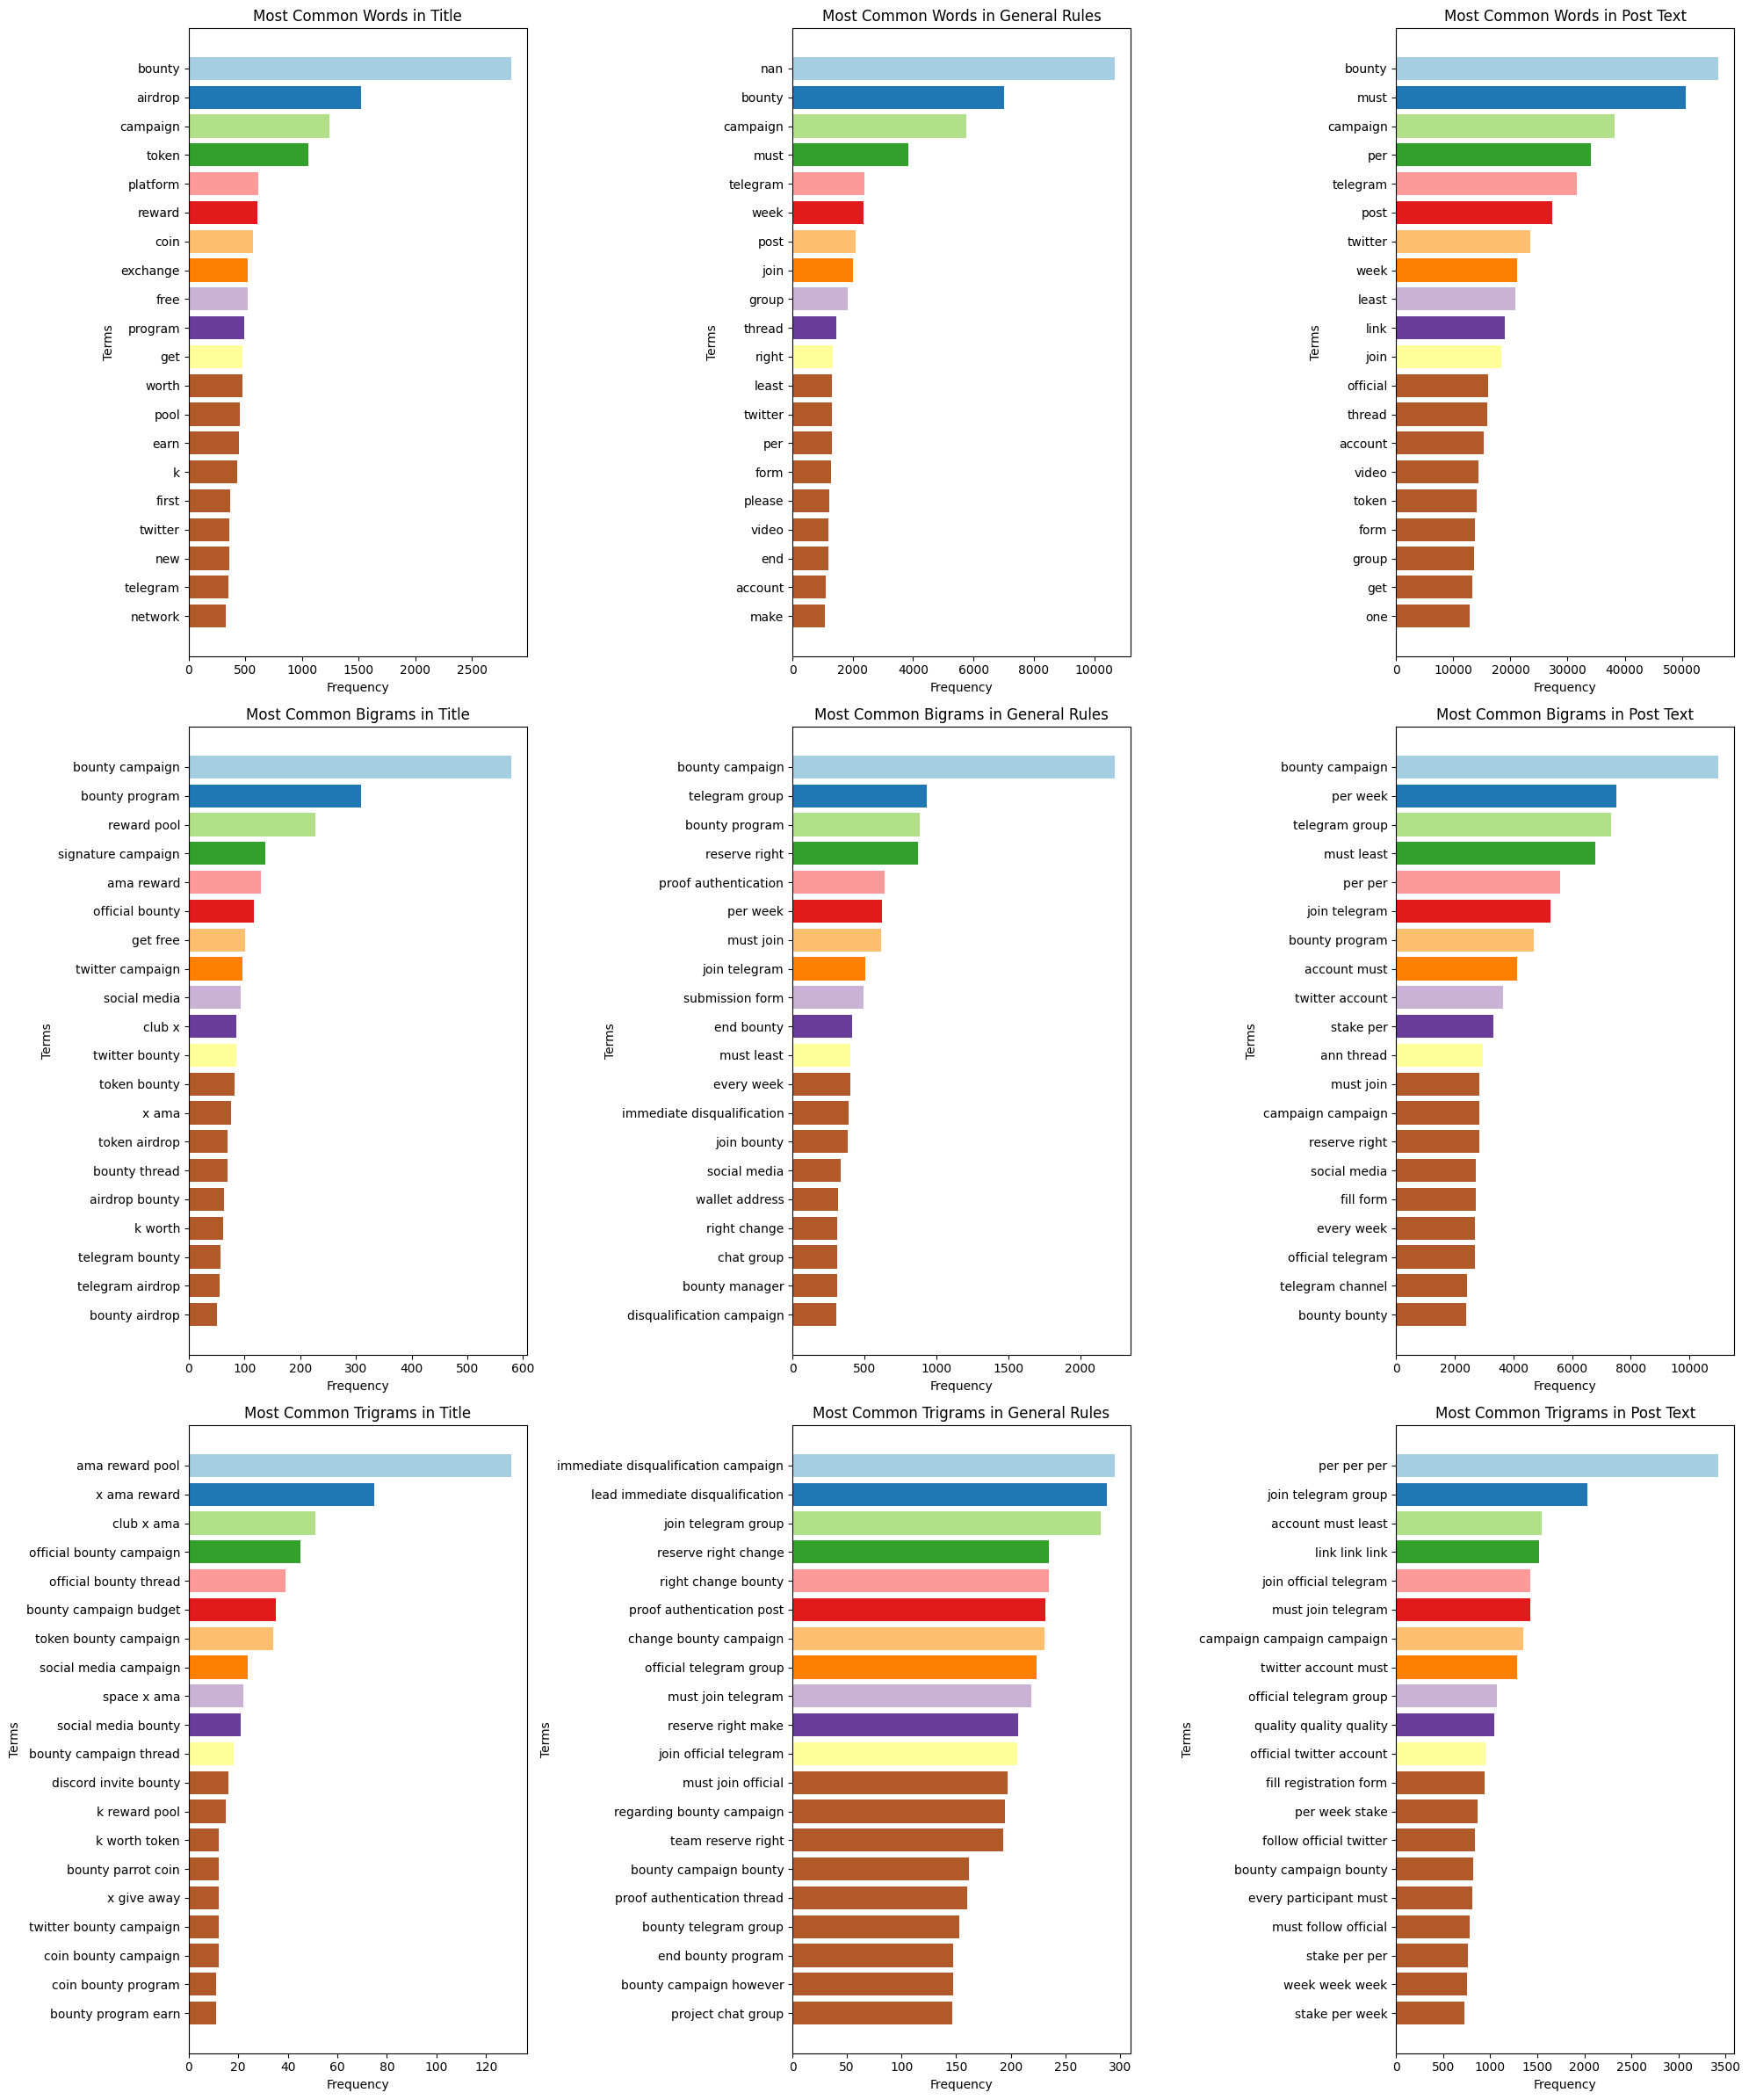

In [14]:
# Function to plot frequency distribution
def plot_freq_distribution(ax, freq_dist, title):
    labels, values = zip(*freq_dist)
    labels = [' '.join(label) if isinstance(label, tuple) else label for label in labels]  # Convert tuples to strings
    ax.barh(labels, values, color=plt.cm.Paired(range(len(freq_dist))))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Terms')

# Create subplots for most common words, bigrams, and trigrams in separate rows
fig, axes = plt.subplots(3, 3, figsize=(20, 24))

# Plot most common words
plot_freq_distribution(axes[0, 0], most_common_clean_title_words, 'Most Common Words in Title')
plot_freq_distribution(axes[0, 1], most_common_general_rules_words, 'Most Common Words in General Rules')
plot_freq_distribution(axes[0, 2], most_common_post_tex_words, 'Most Common Words in Post Text')

# Plot most common bigrams
plot_freq_distribution(axes[1, 0], most_common_clean_title_bigrams, 'Most Common Bigrams in Title')
plot_freq_distribution(axes[1, 1], most_common_general_rules_bigrams, 'Most Common Bigrams in General Rules')
plot_freq_distribution(axes[1, 2], most_common_post_tex_bigrams, 'Most Common Bigrams in Post Text')

# Plot most common trigrams
plot_freq_distribution(axes[2, 0], most_common_clean_title_trigrams, 'Most Common Trigrams in Title')
plot_freq_distribution(axes[2, 1], most_common_general_rules_trigrams, 'Most Common Trigrams in General Rules')
plot_freq_distribution(axes[2, 2], most_common_post_tex_trigrams, 'Most Common Trigrams in Post Text')

# Adjust layout
plt.tight_layout()
plt.show()

### By Category

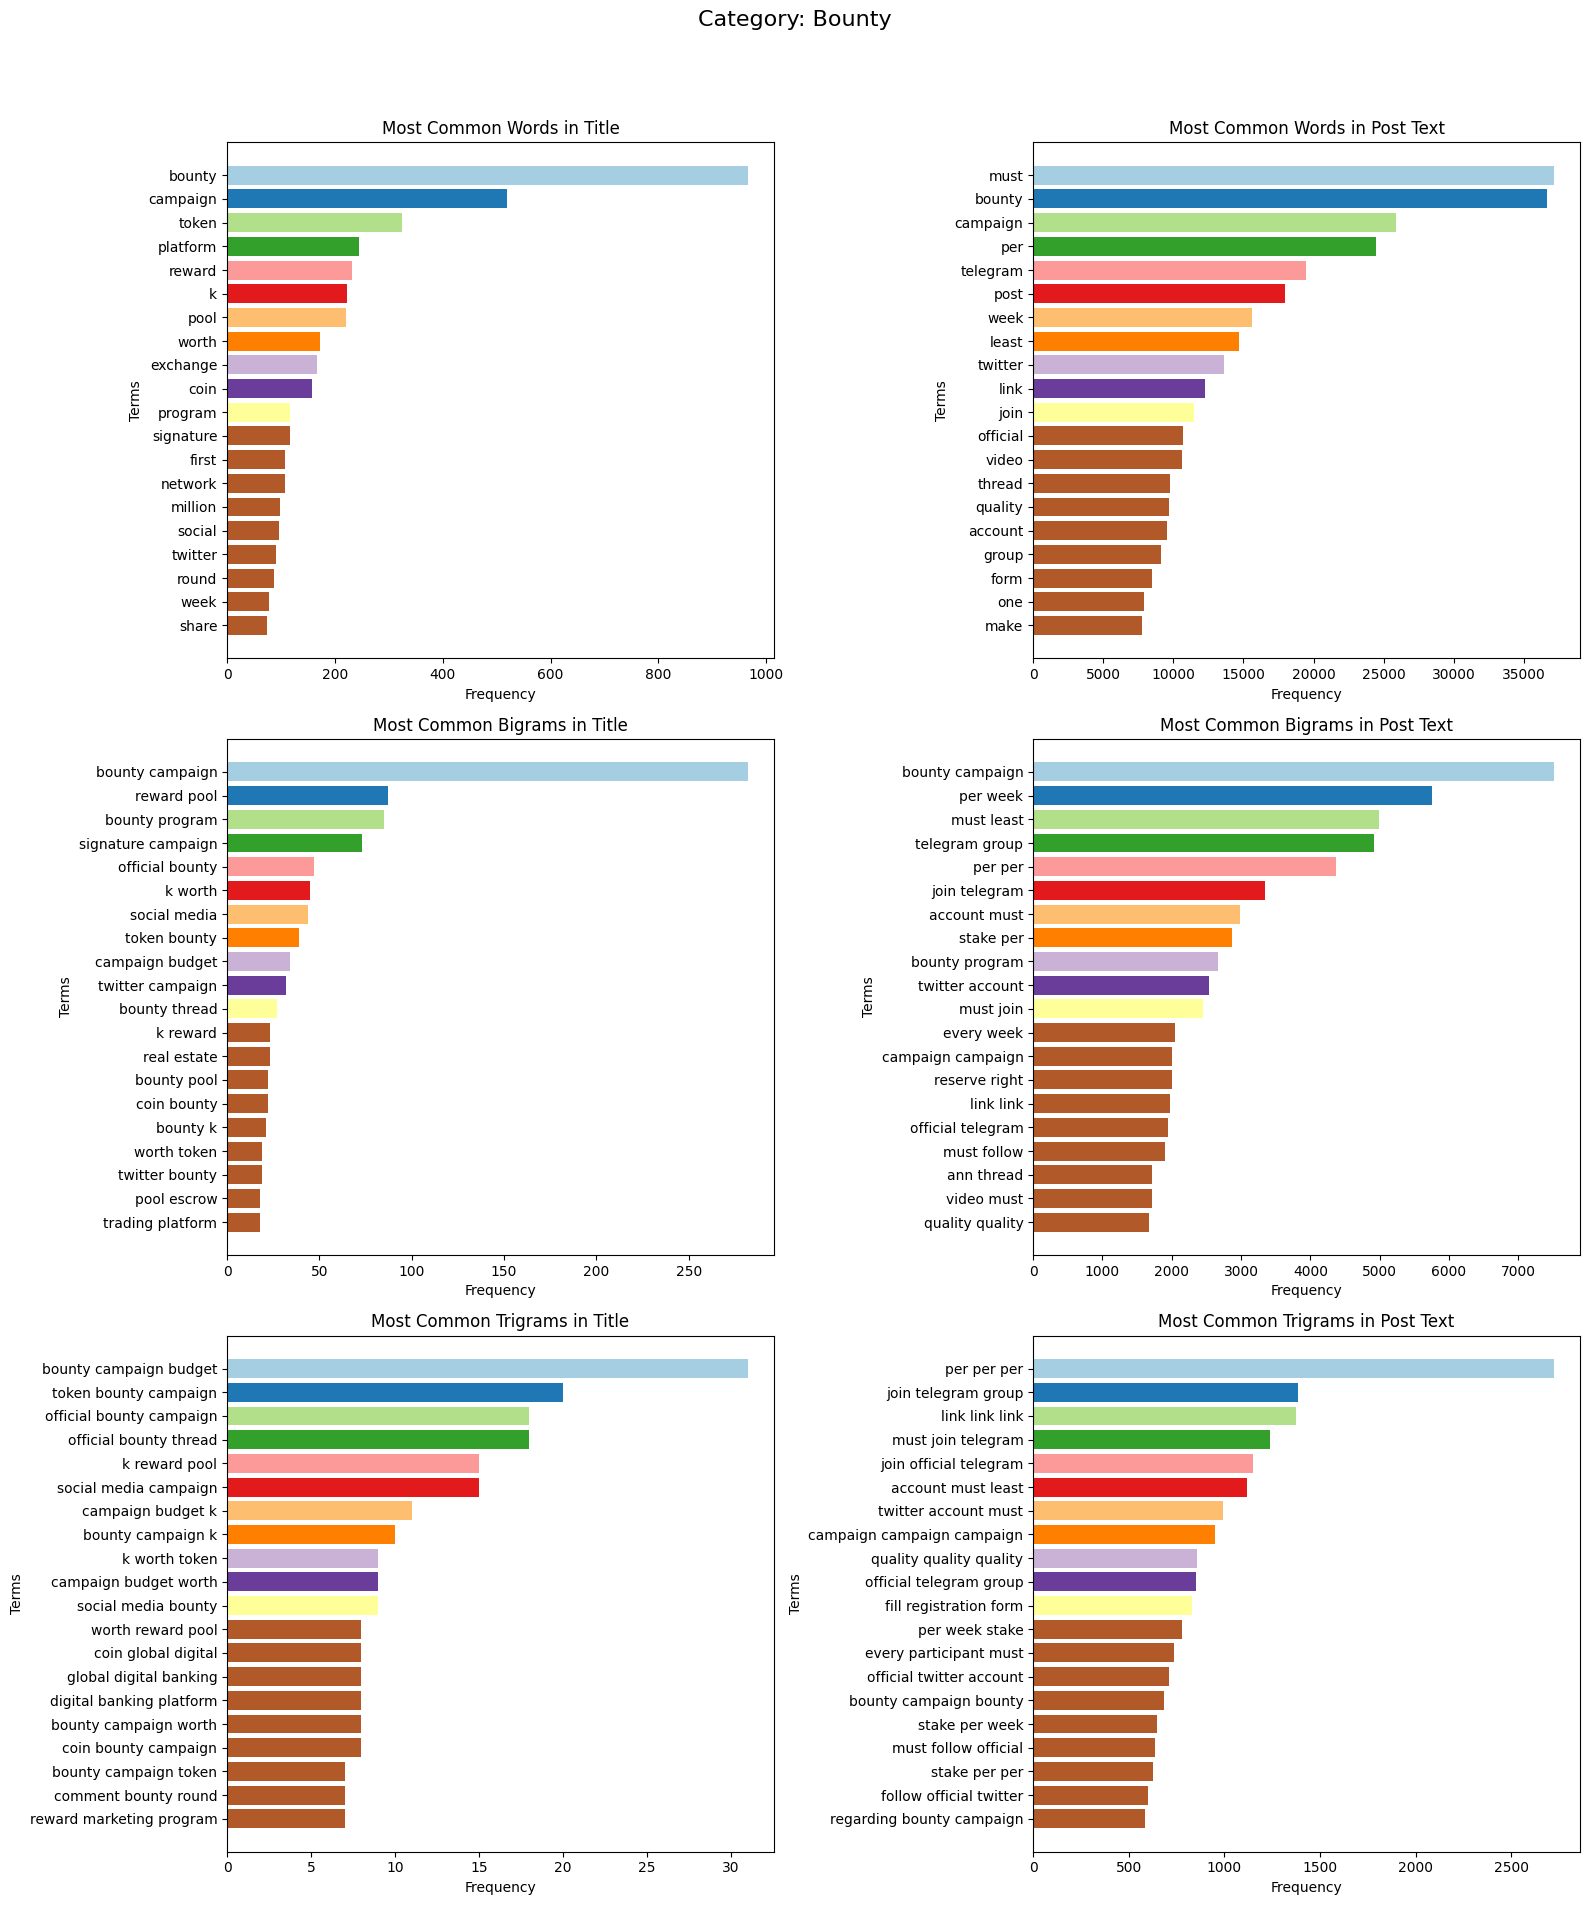

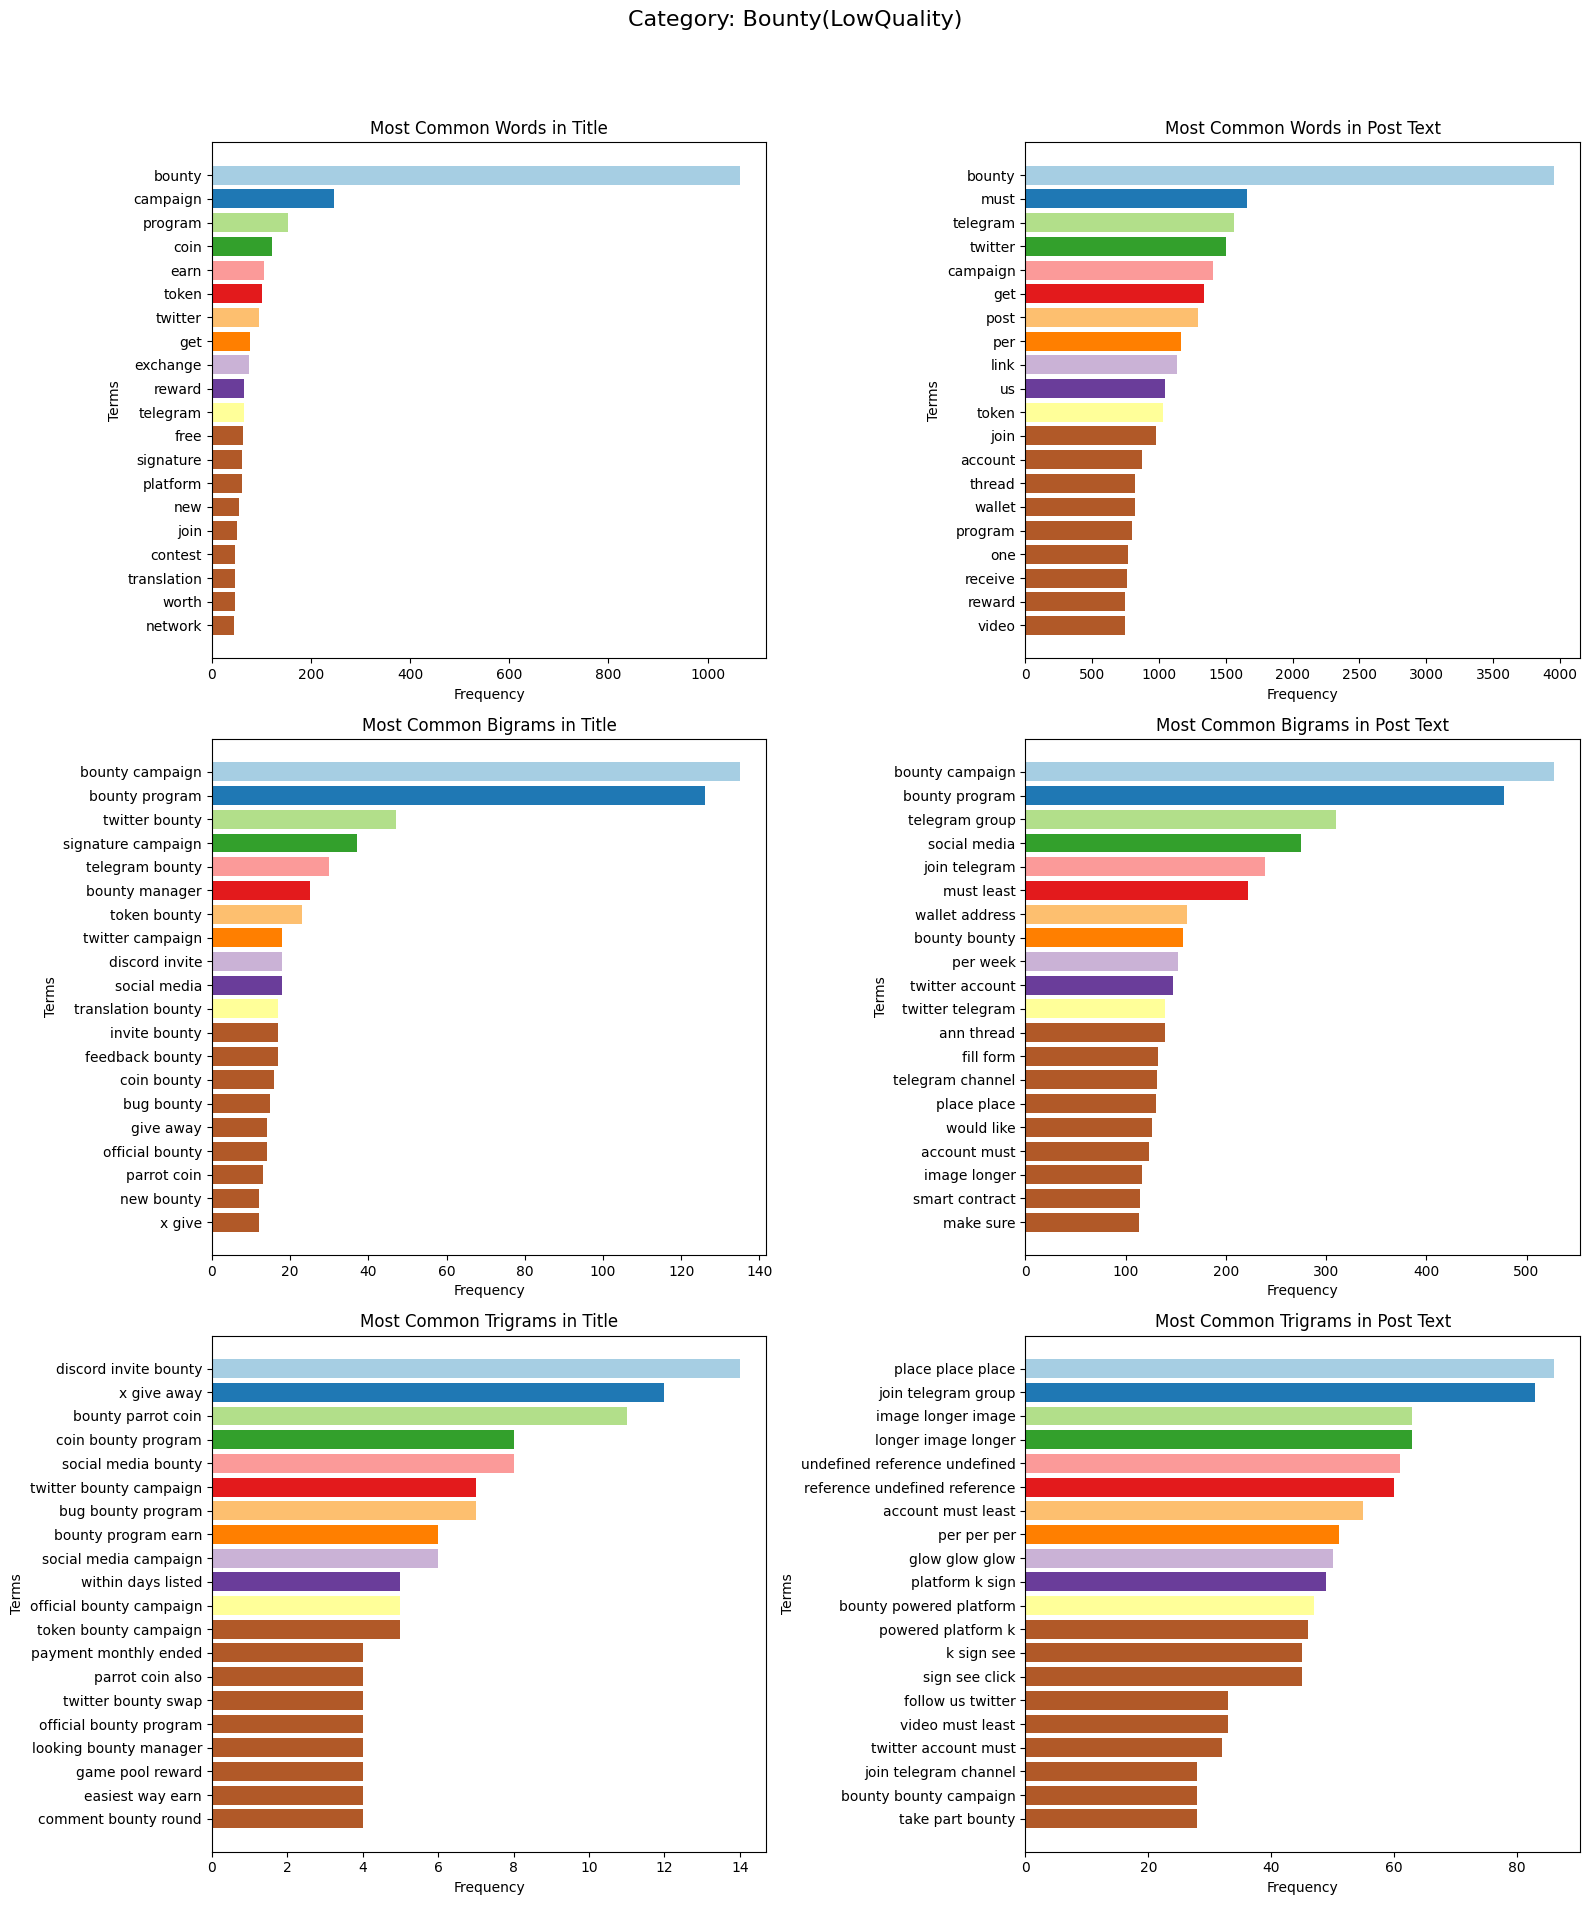

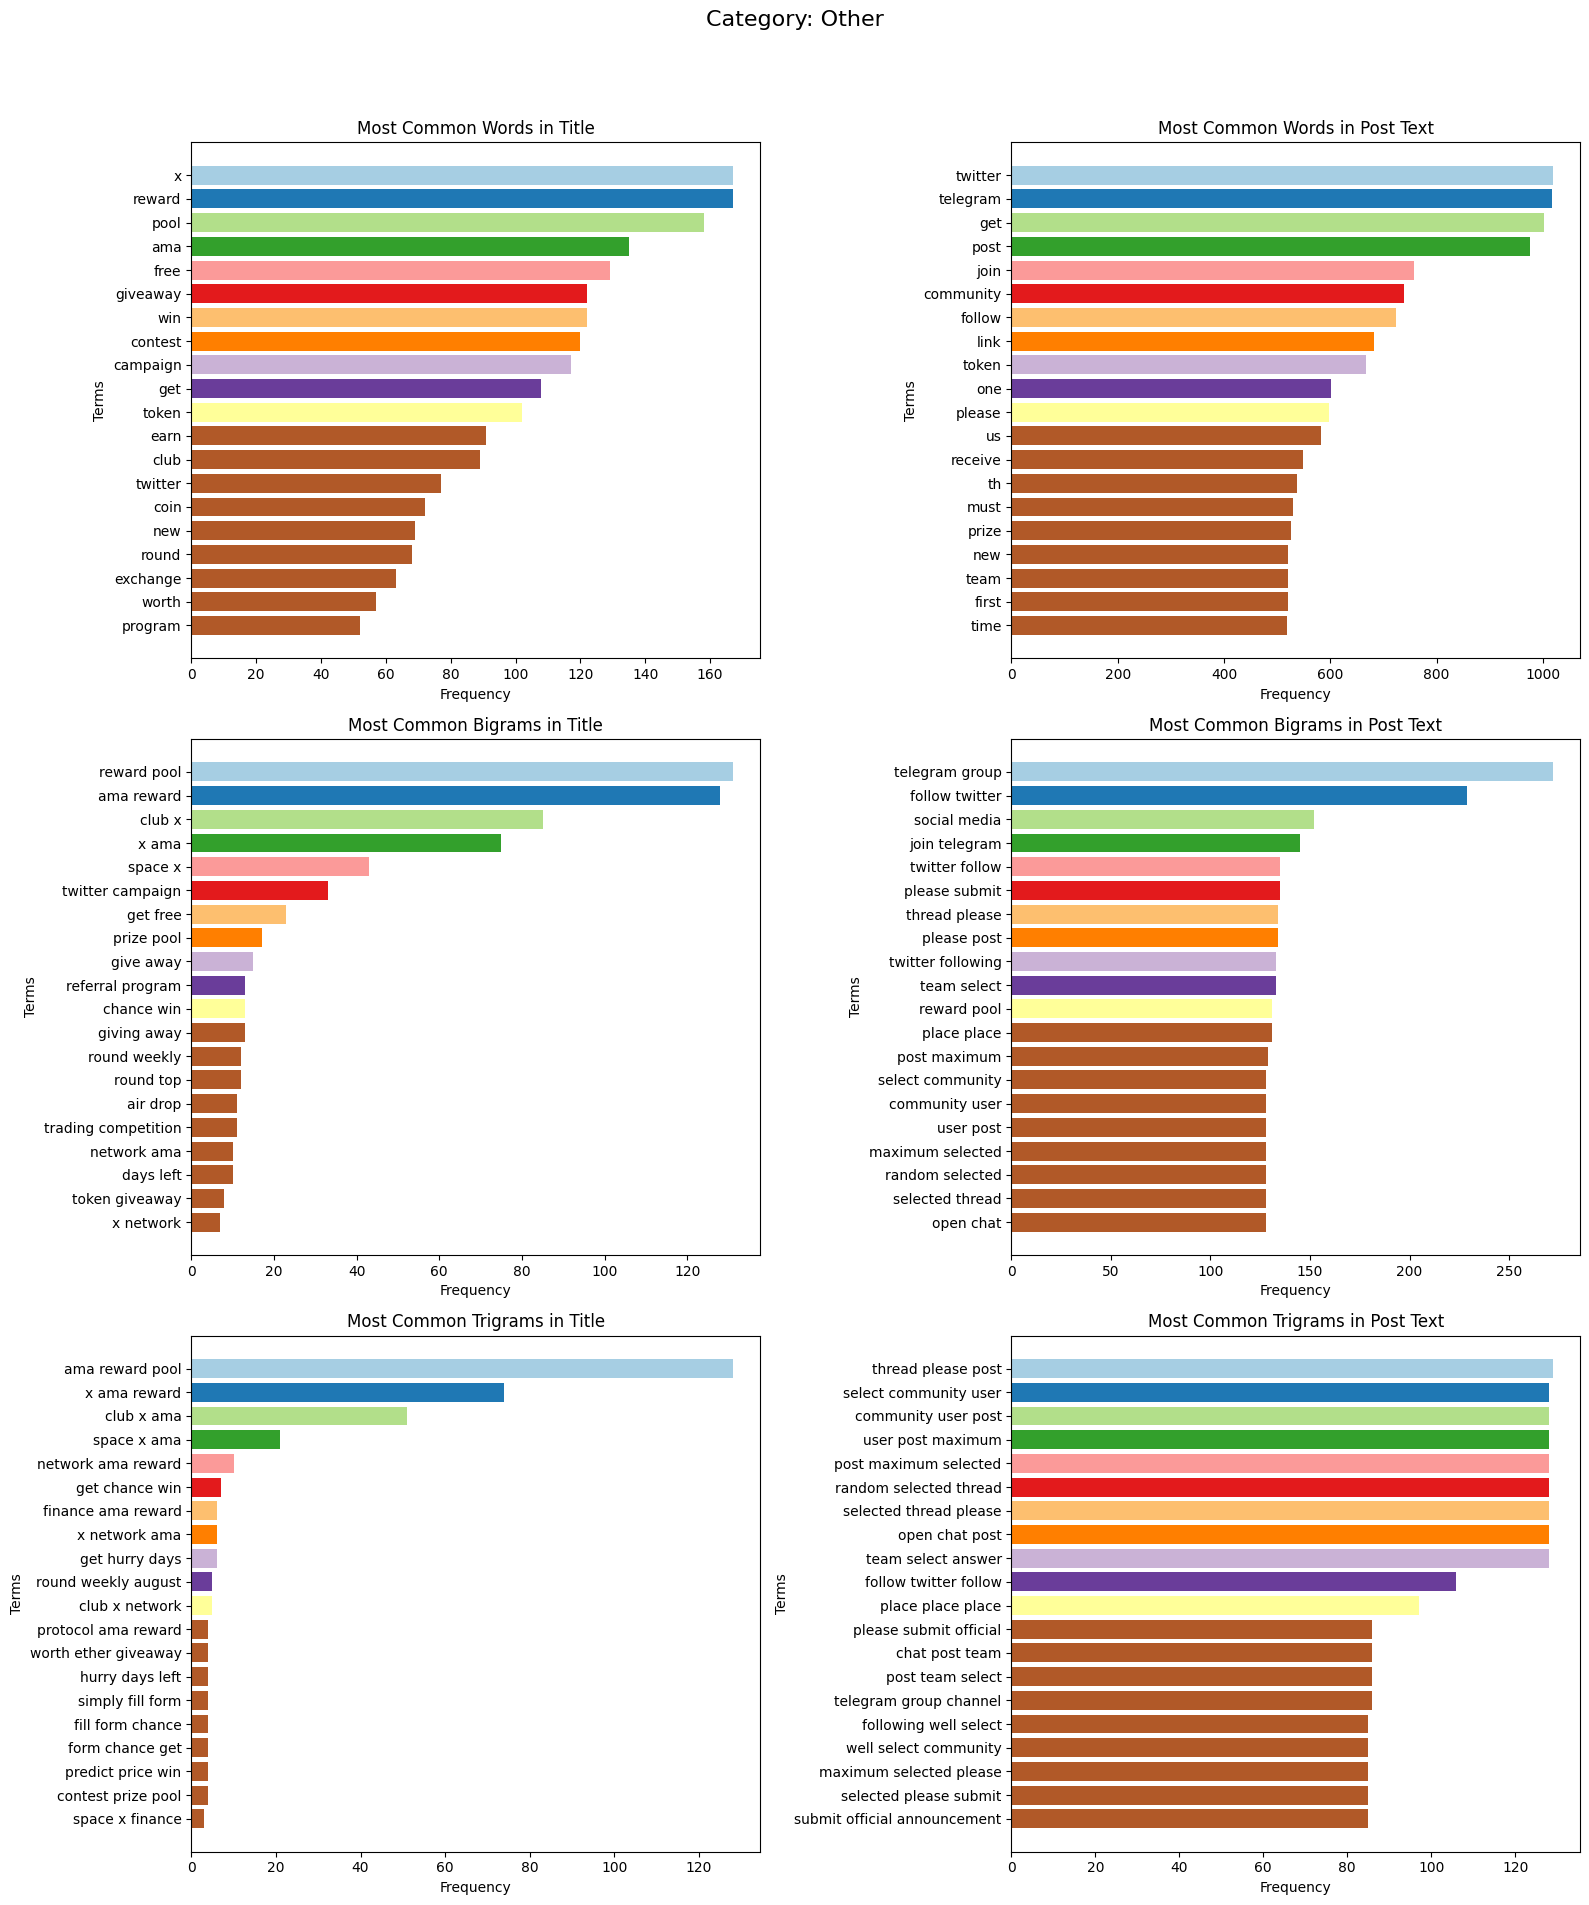

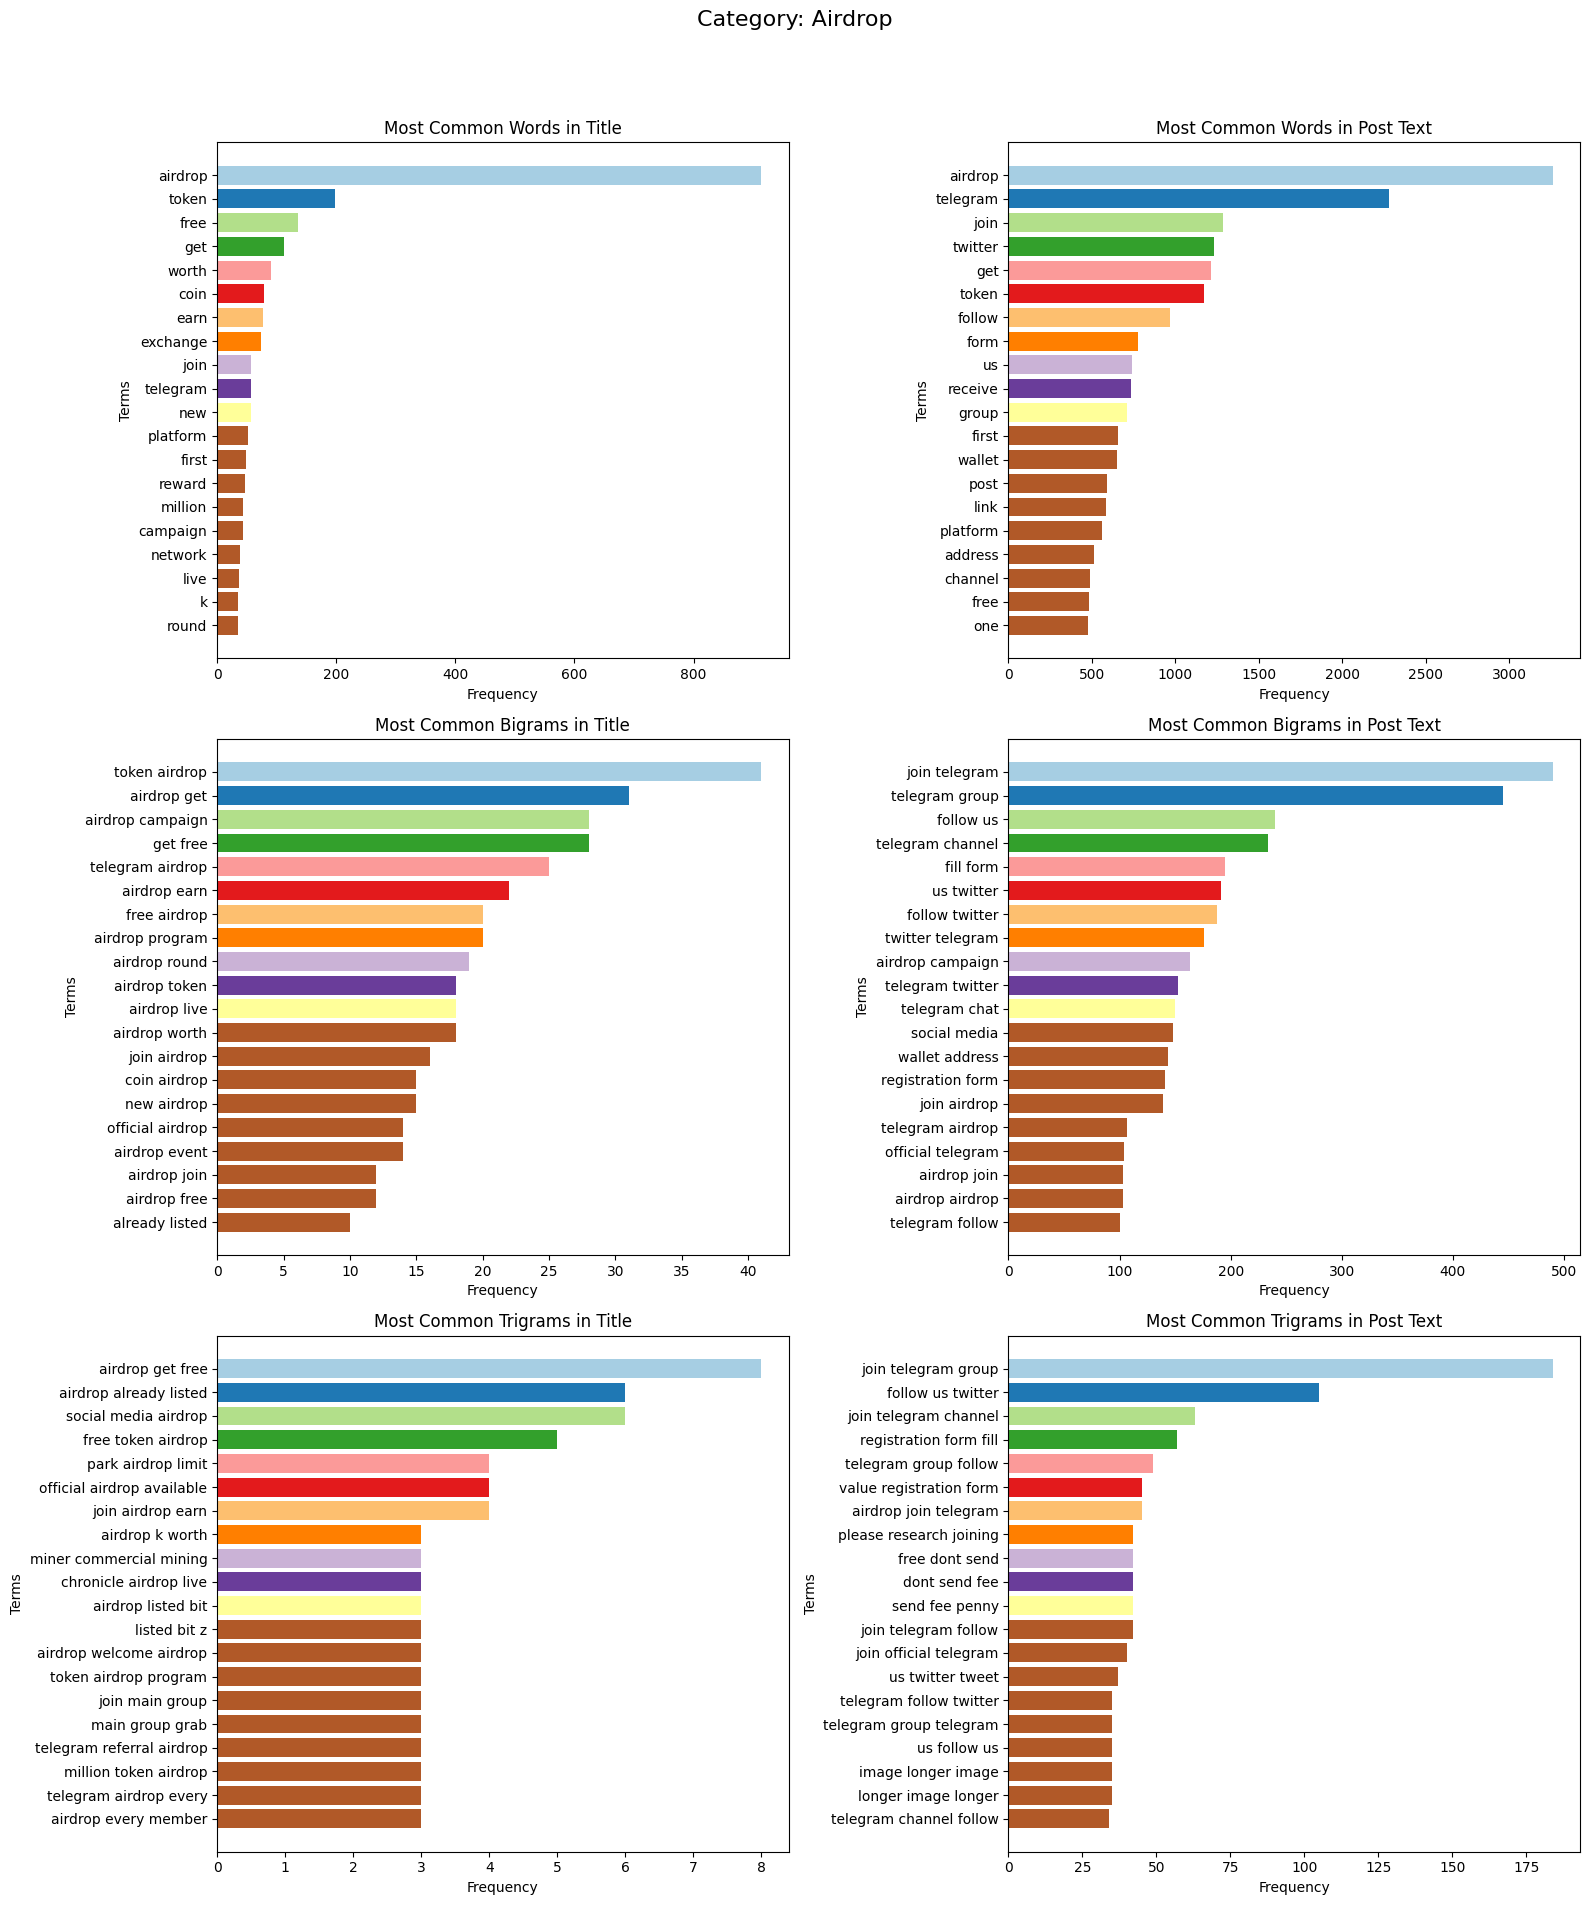

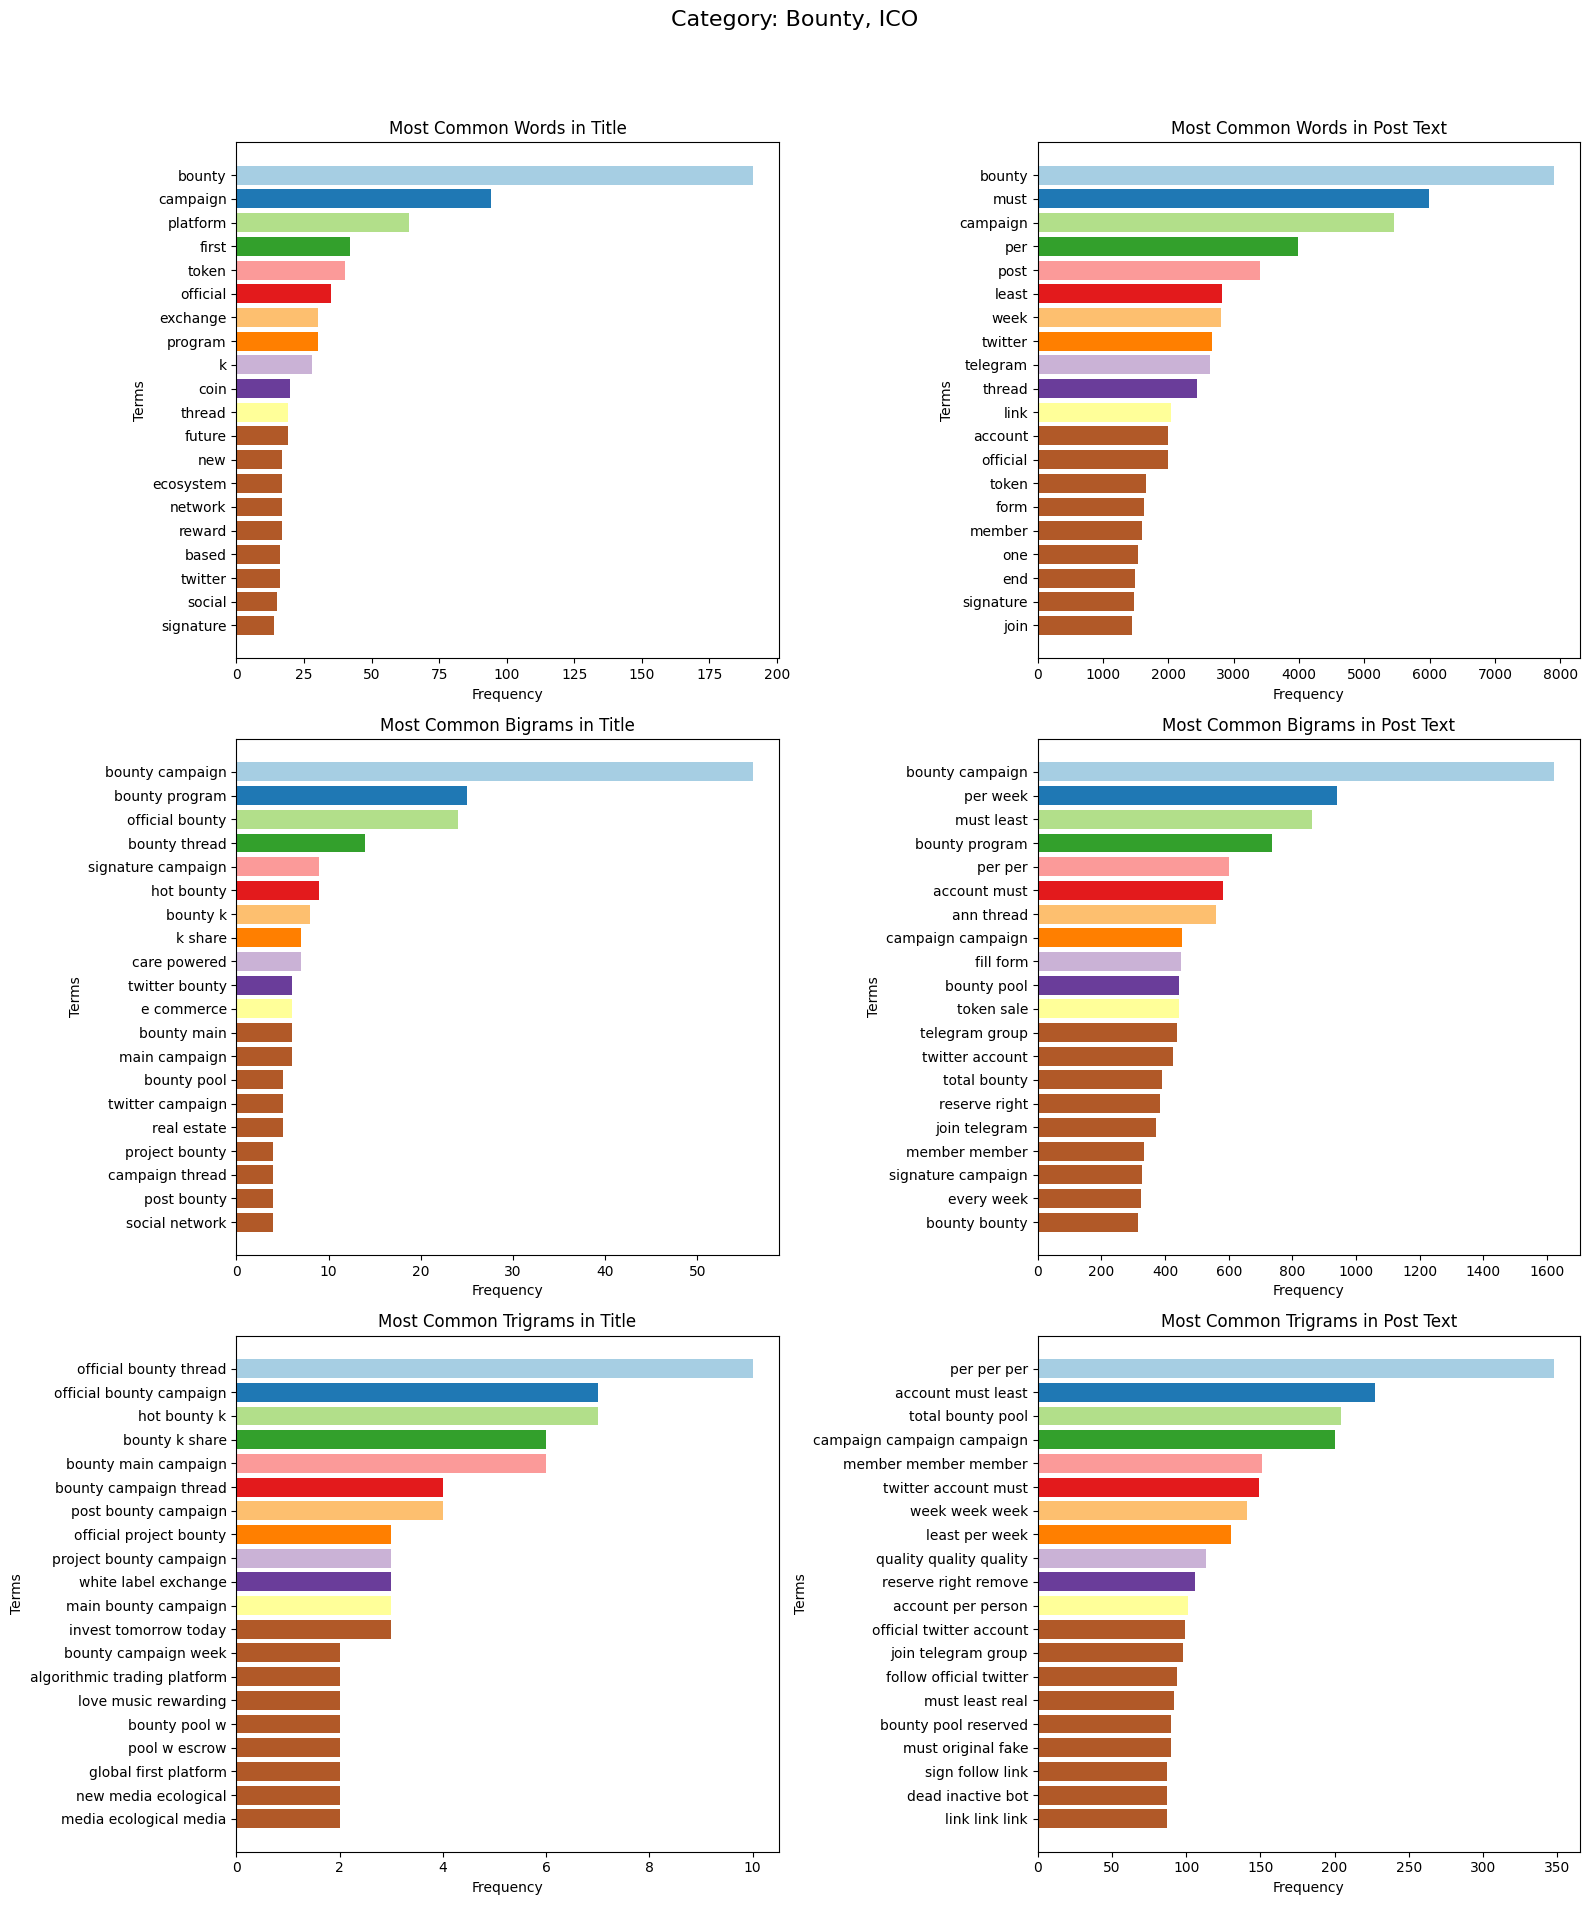

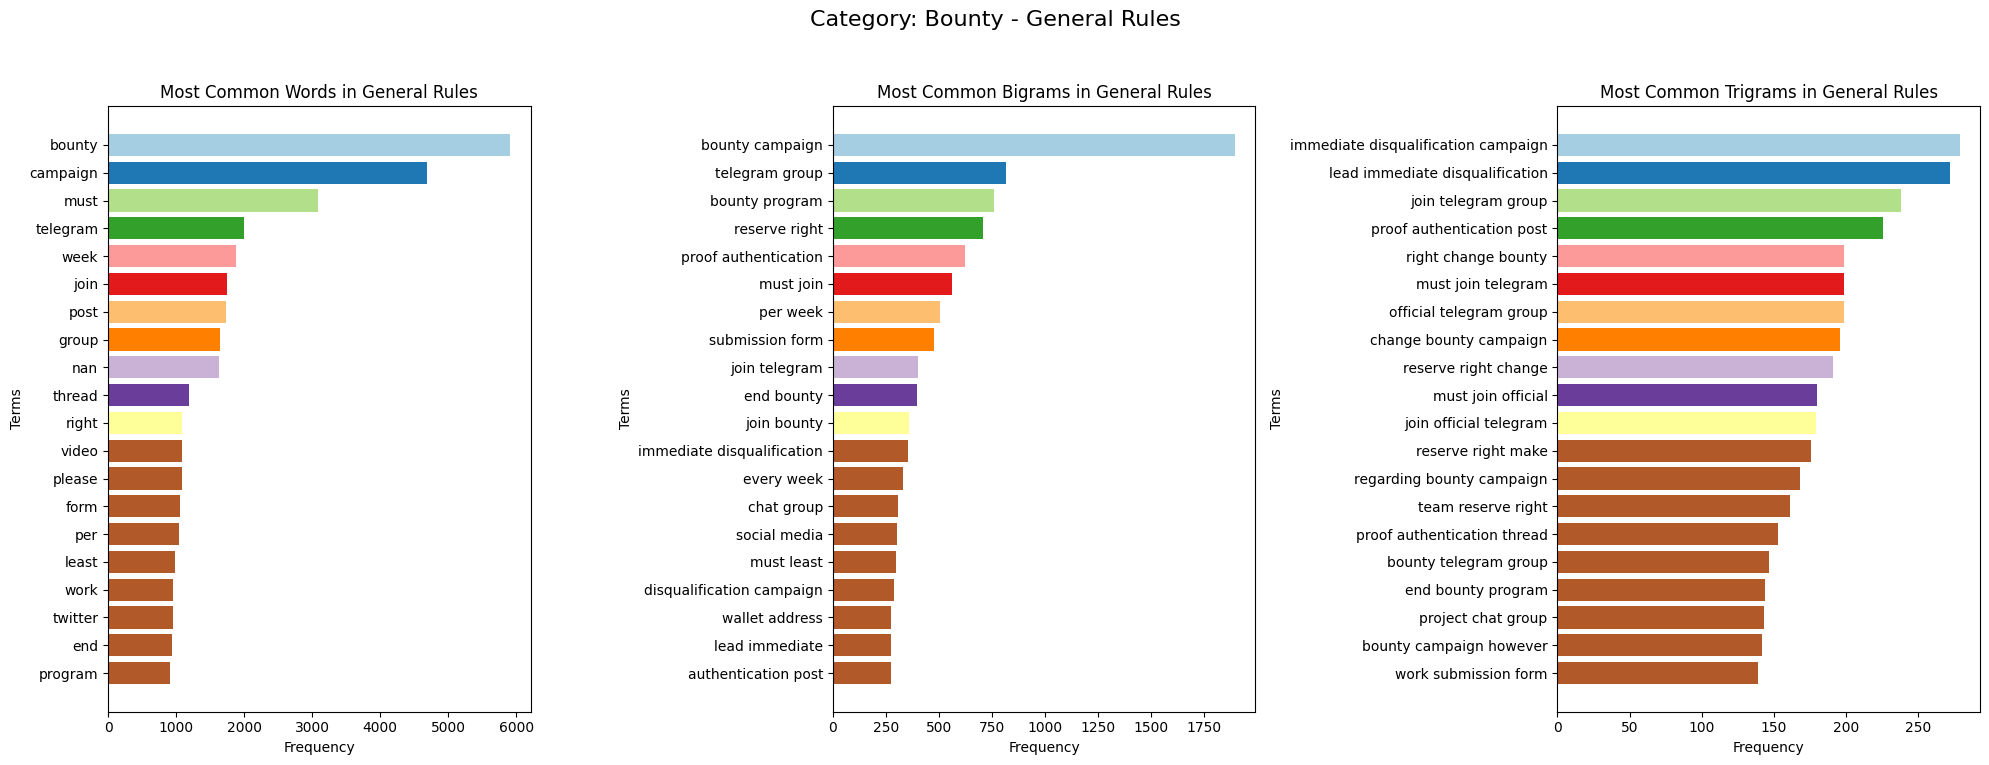

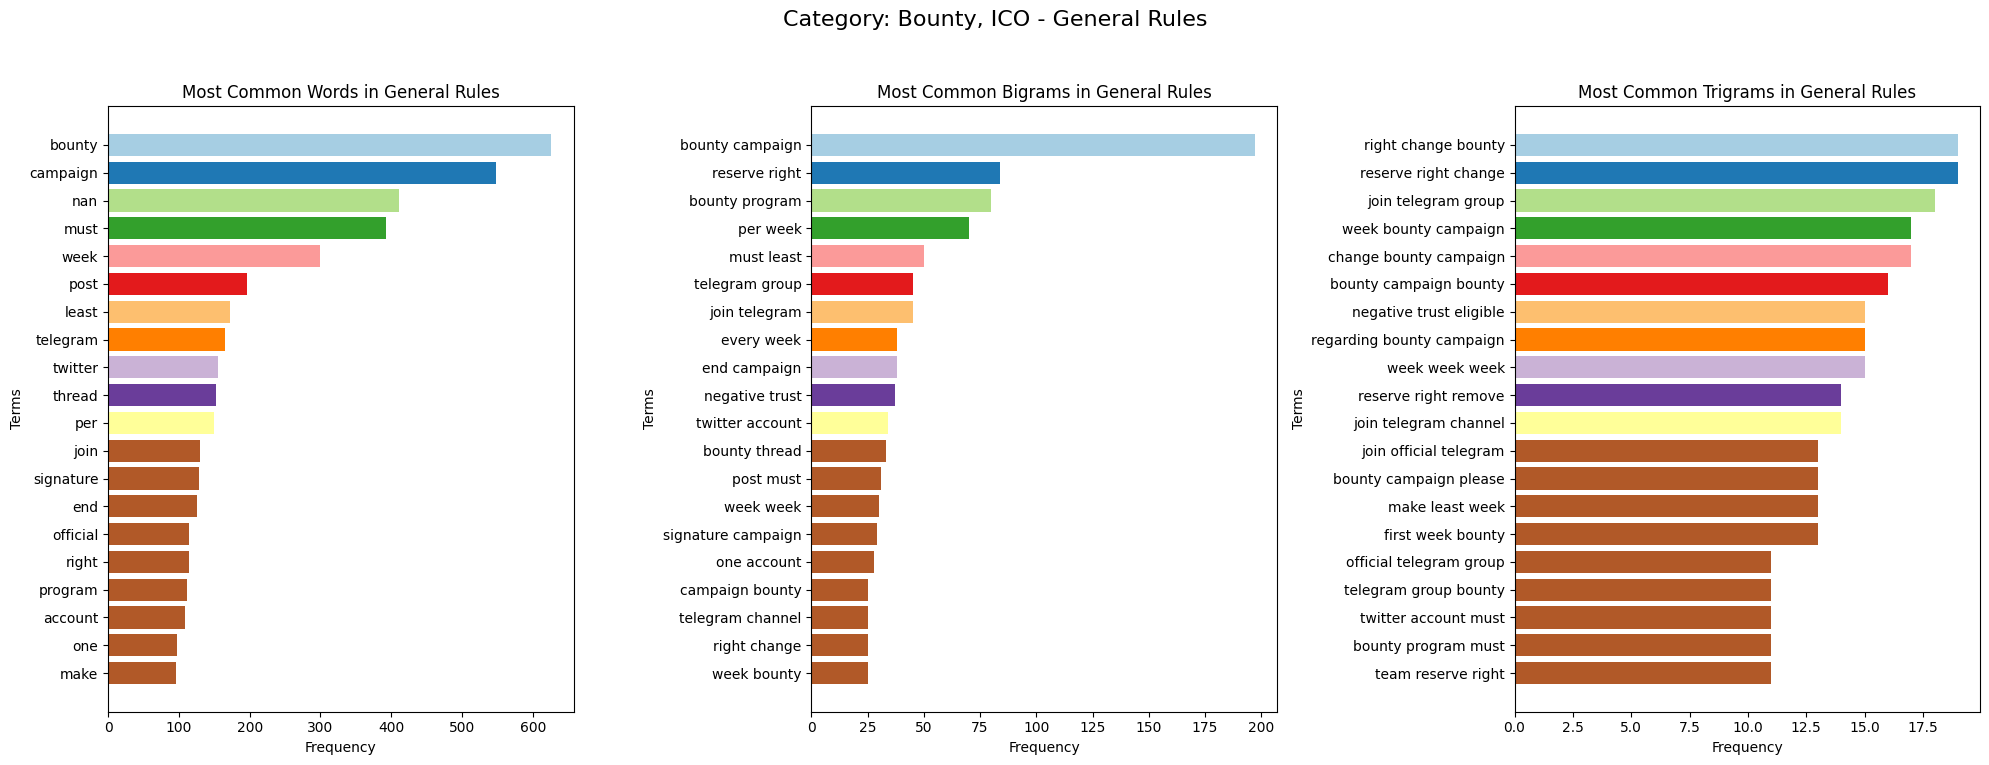

In [16]:
# Create subplots for each category
for category in top_categories:
    category_df = events_df[events_df['categories'] == category]
    
    # Flatten the list of tokens and count frequencies for clean_title
    all_clean_title_tokens = [token for sublist in category_df['clean_title_tokens'] for token in sublist]
    clean_title_word_freq = Counter(all_clean_title_tokens)
    most_common_clean_title_words = clean_title_word_freq.most_common(20)

    # Flatten the list of tokens and count frequencies for post_tex
    all_post_tex_tokens = [token for sublist in category_df['post_tex_tokens'] for token in sublist]
    post_tex_word_freq = Counter(all_post_tex_tokens)
    most_common_post_tex_words = post_tex_word_freq.most_common(20)

    # Find bigrams and trigrams for clean_title
    all_clean_title_bigrams = [bigram for sublist in category_df['clean_title_tokens'] for bigram in bigrams(sublist)]
    all_clean_title_trigrams = [trigram for sublist in category_df['clean_title_tokens'] for trigram in trigrams(sublist)]

    # Count frequencies of bigrams and trigrams for clean_title
    clean_title_bigram_freq = Counter(all_clean_title_bigrams)
    clean_title_trigram_freq = Counter(all_clean_title_trigrams)
    most_common_clean_title_bigrams = clean_title_bigram_freq.most_common(20)
    most_common_clean_title_trigrams = clean_title_trigram_freq.most_common(20)

    # Find bigrams and trigrams for post_tex
    all_post_tex_bigrams = [bigram for sublist in category_df['post_tex_tokens'] for bigram in bigrams(sublist)]
    all_post_tex_trigrams = [trigram for sublist in category_df['post_tex_tokens'] for trigram in trigrams(sublist)]

    # Count frequencies of bigrams and trigrams for post_tex
    post_tex_bigram_freq = Counter(all_post_tex_bigrams)
    post_tex_trigram_freq = Counter(all_post_tex_trigrams)
    most_common_post_tex_bigrams = post_tex_bigram_freq.most_common(20)
    most_common_post_tex_trigrams = post_tex_trigram_freq.most_common(20)

    # Create subplots for the current category
    fig, axes = plt.subplots(3, 2, figsize=(16, 20))
    fig.suptitle(f'Category: {category}', fontsize=16)

    # Plot most common words
    plot_freq_distribution(axes[0, 0], most_common_clean_title_words, 'Most Common Words in Title')
    plot_freq_distribution(axes[0, 1], most_common_post_tex_words, 'Most Common Words in Post Text')

    # Plot most common bigrams
    plot_freq_distribution(axes[1, 0], most_common_clean_title_bigrams, 'Most Common Bigrams in Title')
    plot_freq_distribution(axes[1, 1], most_common_post_tex_bigrams, 'Most Common Bigrams in Post Text')

    # Plot most common trigrams
    plot_freq_distribution(axes[2, 0], most_common_clean_title_trigrams, 'Most Common Trigrams in Title')
    plot_freq_distribution(axes[2, 1], most_common_post_tex_trigrams, 'Most Common Trigrams in Post Text')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Specific analysis for Bounty and ICO categories for general_rules
for category in ['Bounty', 'Bounty, ICO']:
    category_df = events_df[events_df['categories'] == category]
    
    # Flatten the list of tokens and count frequencies for general_rules
    all_general_rules_tokens = [token for sublist in category_df['general_rules_tokens'] for token in sublist]
    general_rules_word_freq = Counter(all_general_rules_tokens)
    most_common_general_rules_words = general_rules_word_freq.most_common(20)

    # Find bigrams and trigrams for general_rules
    all_general_rules_bigrams = [bigram for sublist in category_df['general_rules_tokens'] for bigram in bigrams(sublist)]
    all_general_rules_trigrams = [trigram for sublist in category_df['general_rules_tokens'] for trigram in trigrams(sublist)]

    # Count frequencies of bigrams and trigrams for general_rules
    general_rules_bigram_freq = Counter(all_general_rules_bigrams)
    general_rules_trigram_freq = Counter(all_general_rules_trigrams)
    most_common_general_rules_bigrams = general_rules_bigram_freq.most_common(20)
    most_common_general_rules_trigrams = general_rules_trigram_freq.most_common(20)

    # Create subplots for the current category
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle(f'Category: {category} - General Rules', fontsize=16)

    # Plot most common words in general_rules
    plot_freq_distribution(axes[0], most_common_general_rules_words, 'Most Common Words in General Rules')

    # Plot most common bigrams in general_rules
    plot_freq_distribution(axes[1], most_common_general_rules_bigrams, 'Most Common Bigrams in General Rules')

    # Plot most common trigrams in general_rules
    plot_freq_distribution(axes[2], most_common_general_rules_trigrams, 'Most Common Trigrams in General Rules')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### TD-IDF

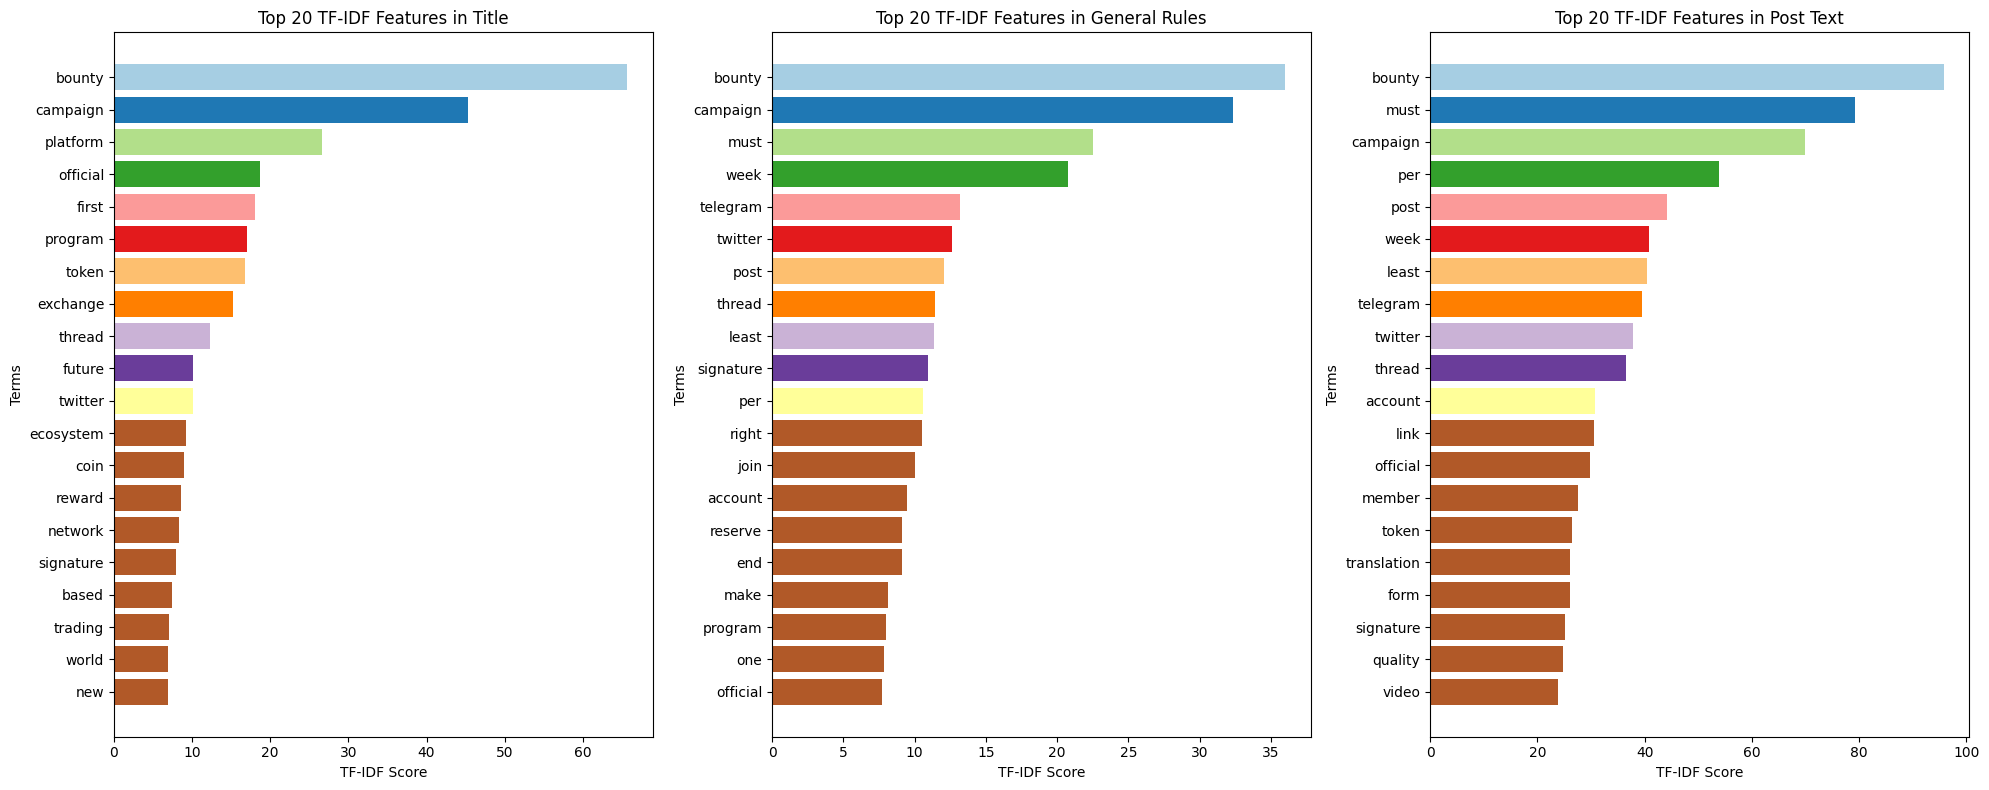

In [18]:
# Define a function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'<#NewLine>', ' ', text)  # Remove <#NewLine> tags
    text = re.sub(r'nan', ' ', text)  # Remove 'nan' values
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english') and word in english_words]  # Remove stop words and non-English words
    return ' '.join(tokens)  # Return tokens as string

# Apply preprocessing separately
events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# Get top 5 categories
top_categories = events_df['categories'].value_counts().nlargest(5).index

# Function to get top n TF-IDF scores
def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=20):
    sorted_indices = tfidf_matrix.sum(axis=0).A1.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], tfidf_matrix[:, i].sum()) for i in sorted_indices]
    return top_features

# Function to plot TF-IDF distribution
def plot_tfidf_distribution(ax, tfidf_features, title):
    labels, values = zip(*tfidf_features)
    ax.barh(labels, values, color=plt.cm.Paired(range(len(tfidf_features))))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Terms')
    
# Compute TF-IDF for clean_title
tfidf_vectorizer_ct = TfidfVectorizer()
tfidf_matrix_ct = tfidf_vectorizer_ct.fit_transform(category_df['clean_title_tokens'])
feature_names_ct = tfidf_vectorizer_ct.get_feature_names_out()
top_tfidf_features_ct = get_top_tfidf_features(tfidf_matrix_ct, feature_names_ct)

# Compute TF-IDF for clean_general_rules
tfidf_vectorizer_gr = TfidfVectorizer()
tfidf_matrix_gr = tfidf_vectorizer_gr.fit_transform(category_df['general_rules_tokens'])
feature_names_gr = tfidf_vectorizer_gr.get_feature_names_out()
top_tfidf_features_gr = get_top_tfidf_features(tfidf_matrix_gr, feature_names_gr)

    
# Compute TF-IDF for post_tex
tfidf_vectorizer_pt = TfidfVectorizer()
tfidf_matrix_pt = tfidf_vectorizer_pt.fit_transform(category_df['post_tex_tokens'])
feature_names_pt = tfidf_vectorizer_pt.get_feature_names_out()
top_tfidf_features_pt = get_top_tfidf_features(tfidf_matrix_pt, feature_names_pt)


# Plot TF-IDF scores in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot for clean_title
plot_tfidf_distribution(axes[0], top_tfidf_features_ct, 'Top 20 TF-IDF Features in Title')

# Plot for general_rules
plot_tfidf_distribution(axes[1], top_tfidf_features_gr, 'Top 20 TF-IDF Features in General Rules')

# Plot for post_tex
plot_tfidf_distribution(axes[2], top_tfidf_features_pt, 'Top 20 TF-IDF Features in Post Text')

# Adjust layout
plt.tight_layout()
plt.show()




### By Category

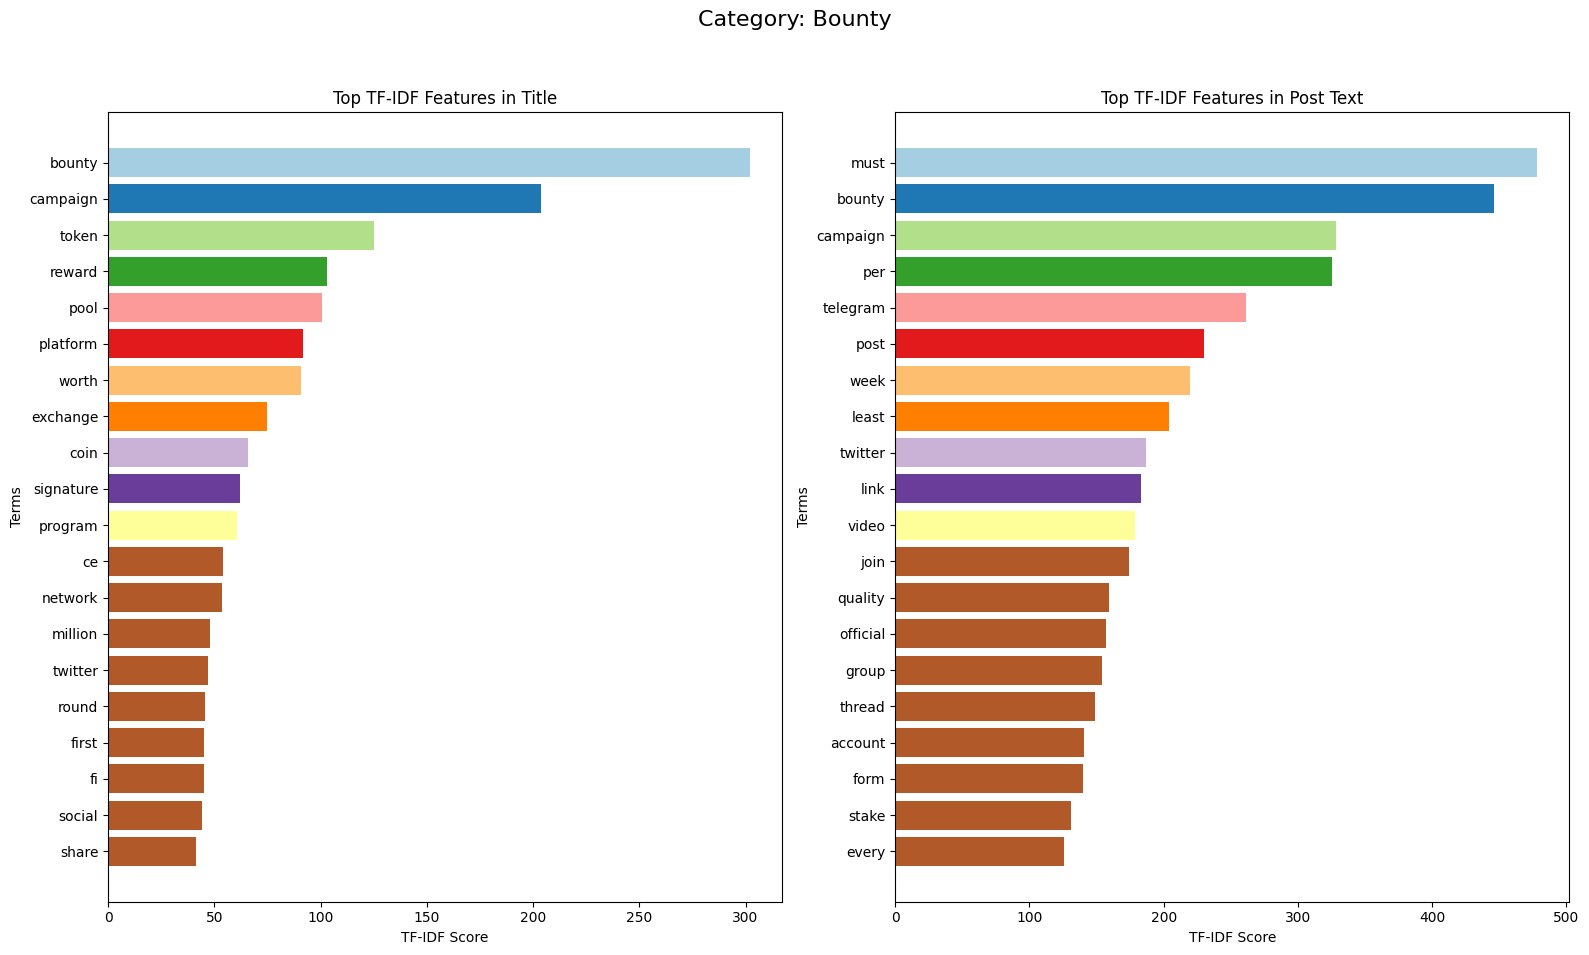

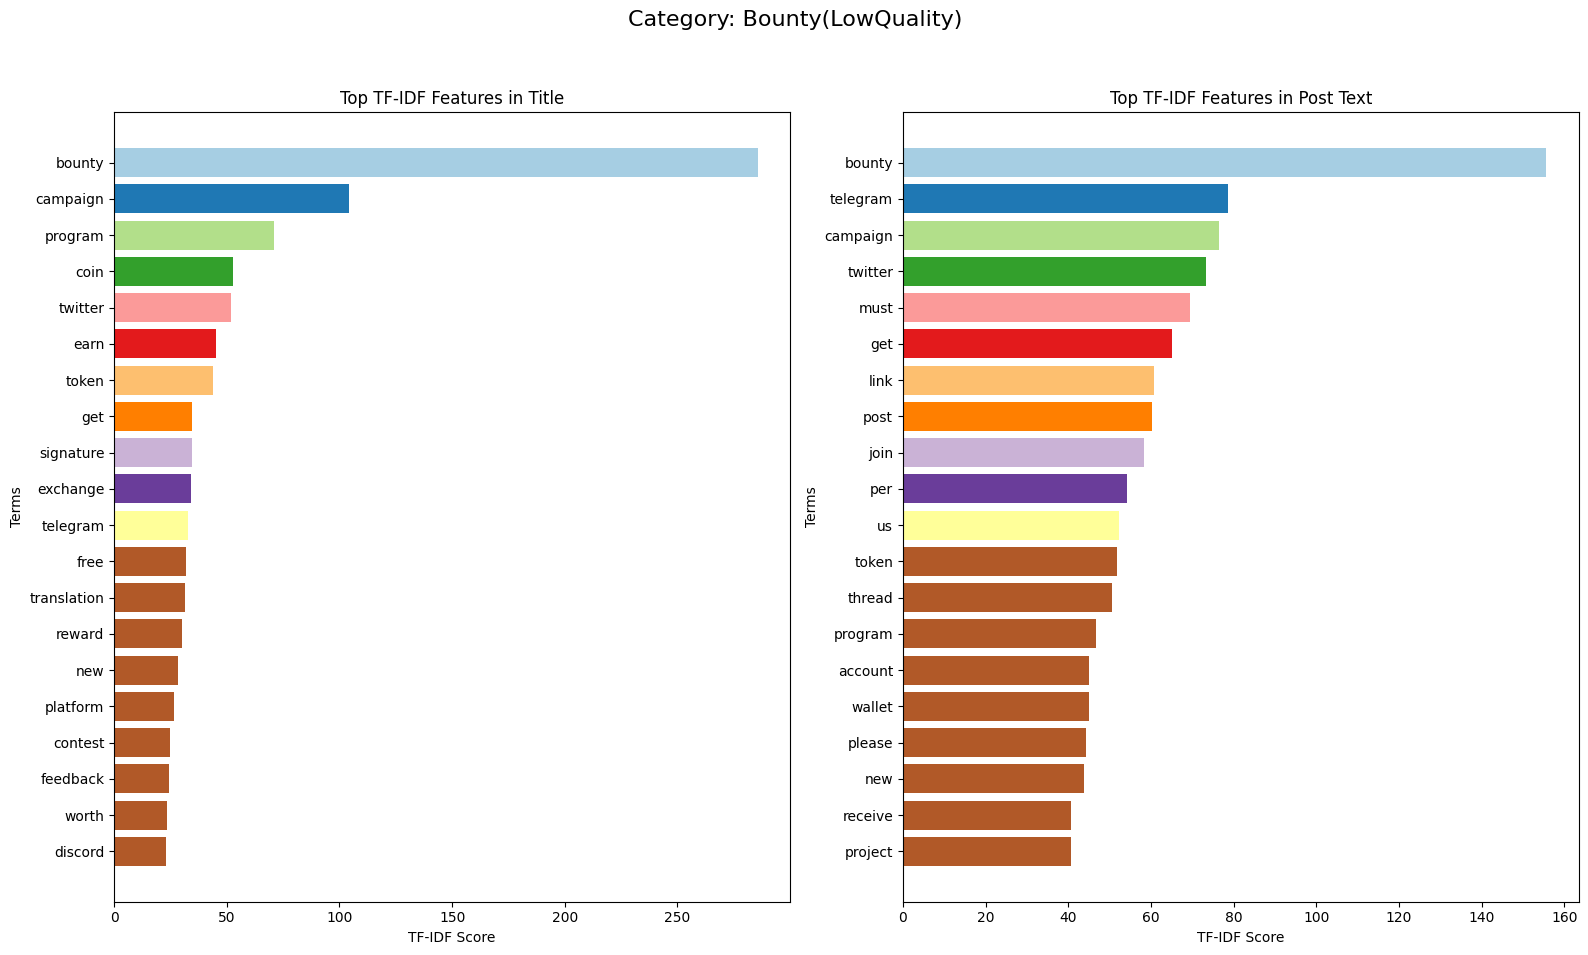

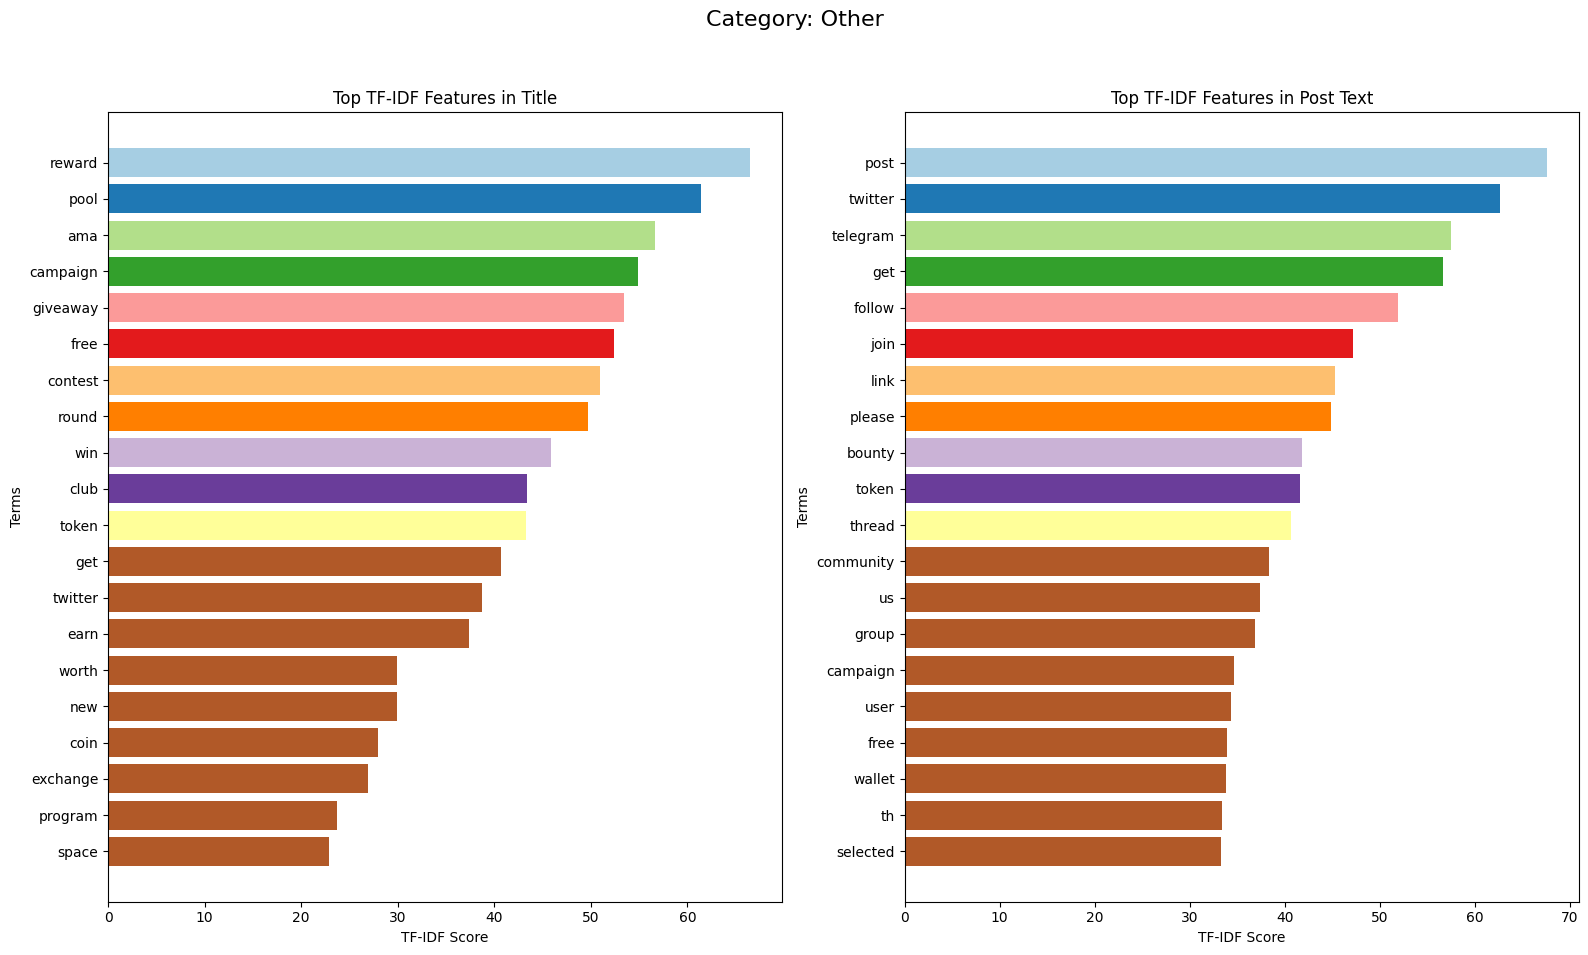

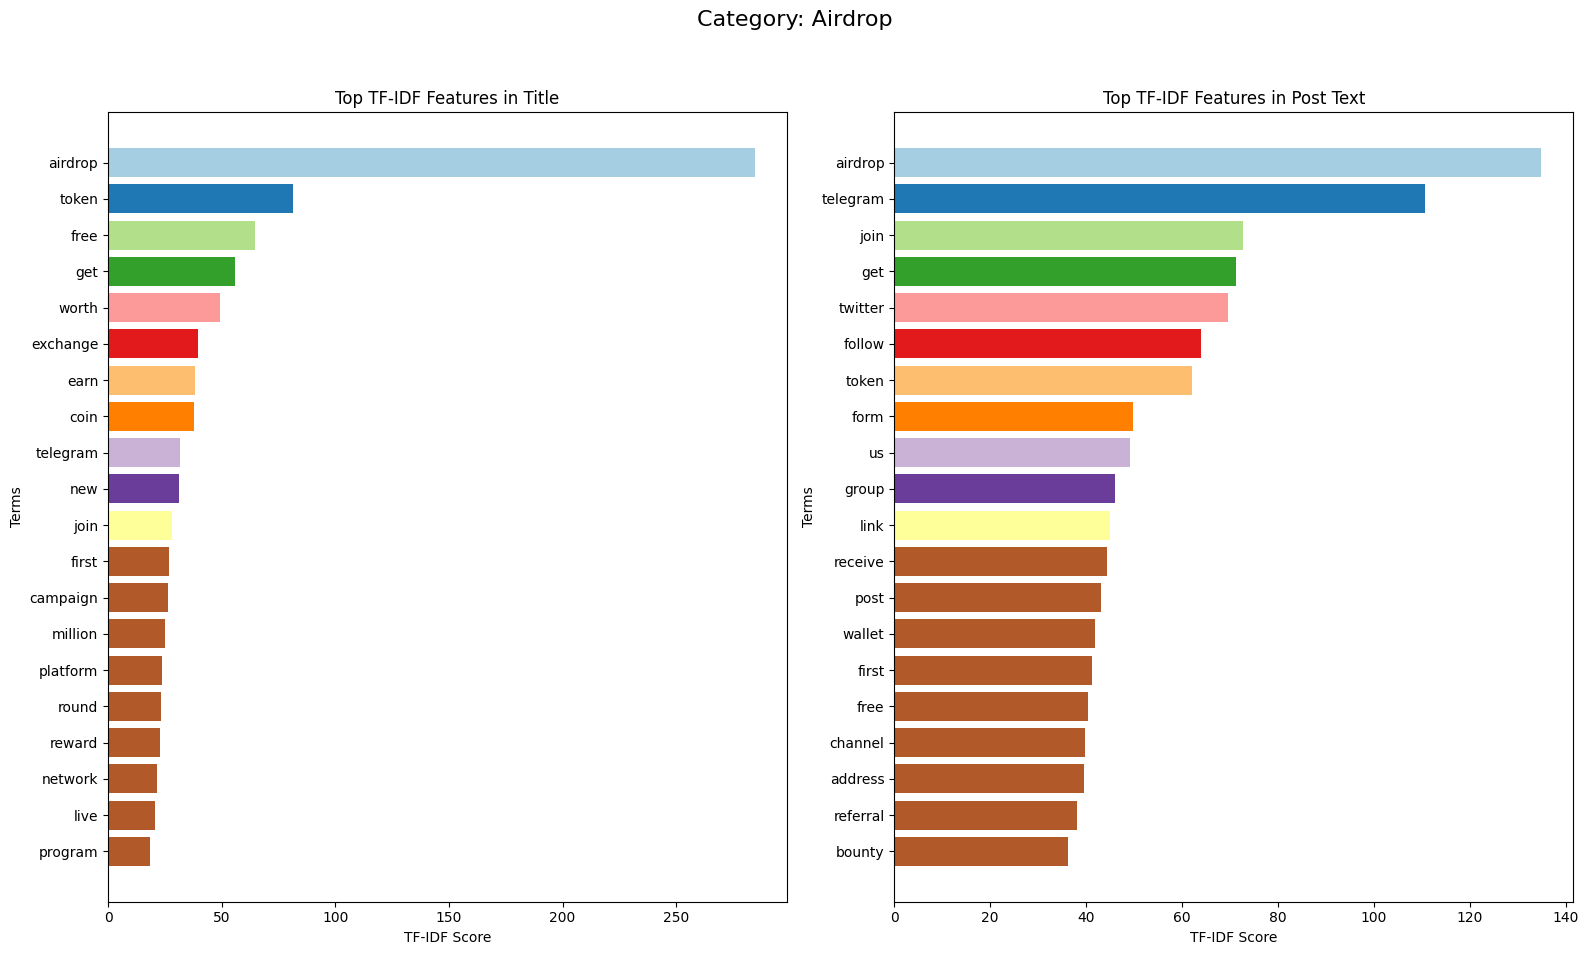

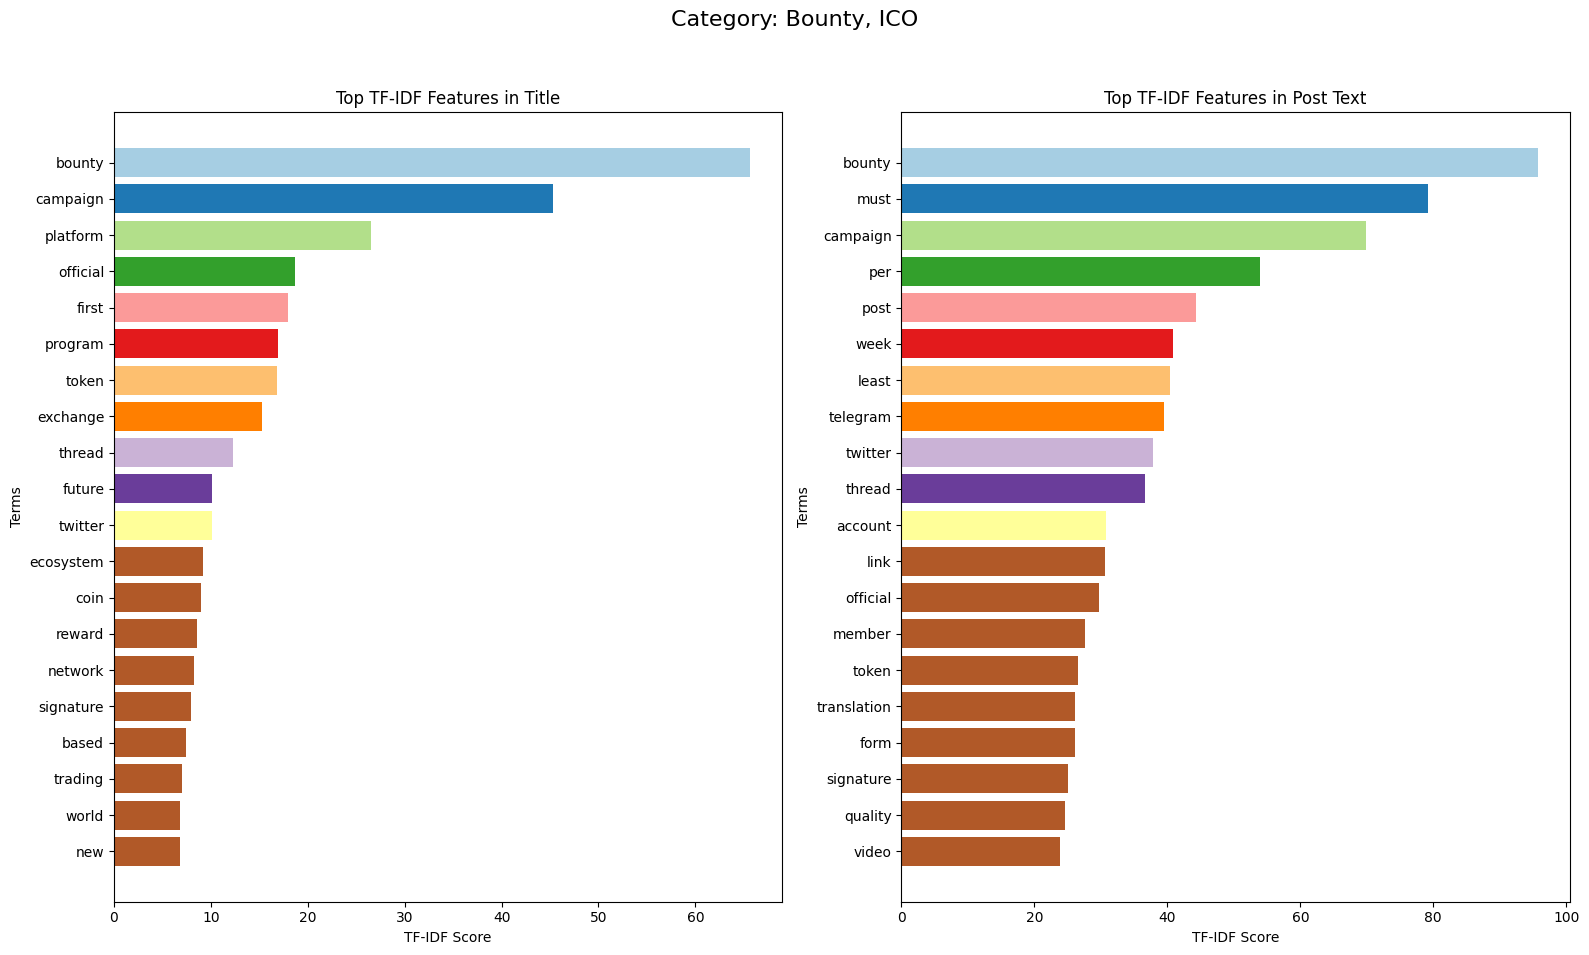

/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules'] = category_df['general_rules'].astype(str)
/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)


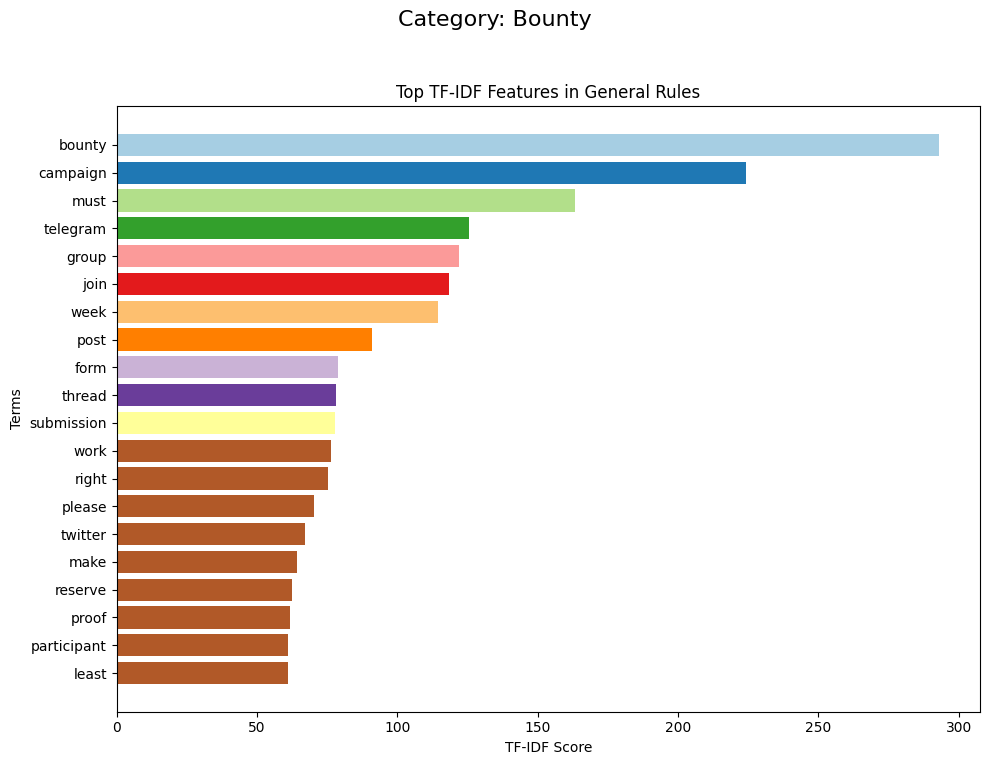

/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules'] = category_df['general_rules'].astype(str)
/var/folders/93/y0v8bb7572q0b03vypbztgzc0000gp/T/ipykernel_72236/4120225684.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)


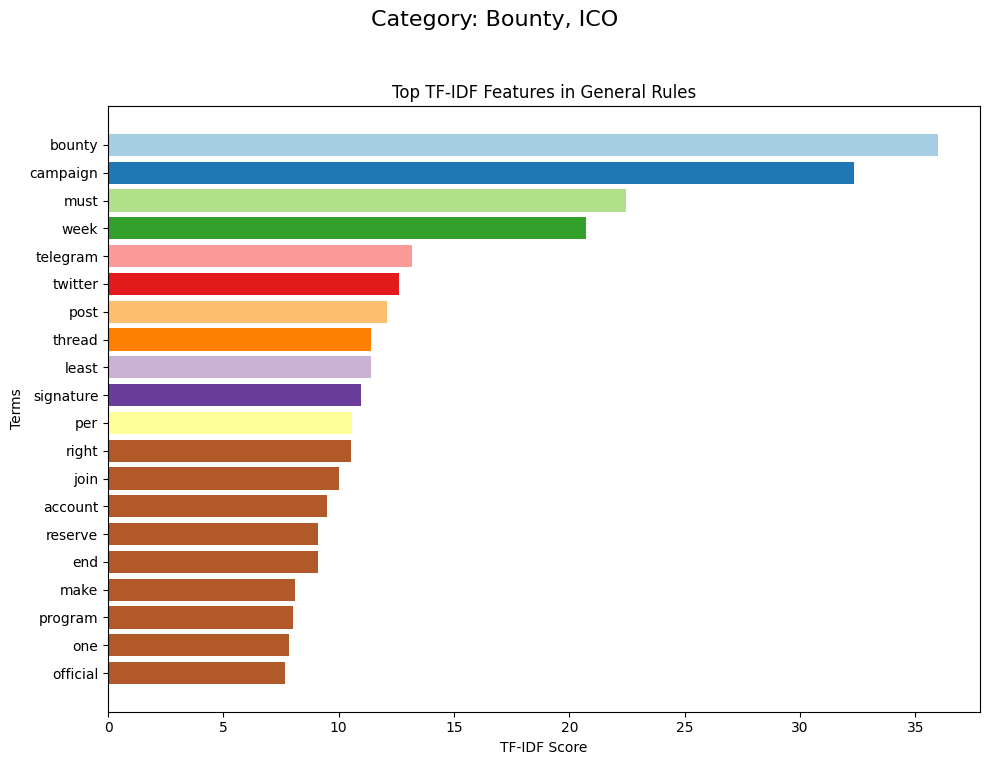

In [19]:
# Apply preprocessing separately
events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# Get top 5 categories
top_categories = events_df['categories'].value_counts().nlargest(5).index

# Function to get top n TF-IDF scores
def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=20):
    sorted_indices = tfidf_matrix.sum(axis=0).A1.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], tfidf_matrix[:, i].sum()) for i in sorted_indices]
    return top_features

# Function to plot TF-IDF distribution
def plot_tfidf_distribution(ax, tfidf_features, title):
    labels, values = zip(*tfidf_features)
    ax.barh(labels, values, color=plt.cm.Paired(range(len(tfidf_features))))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Terms')

# Create subplots for each category
for category in top_categories:
    category_df = events_df[events_df['categories'] == category]
    
    # Compute TF-IDF for clean_title
    tfidf_vectorizer_ct = TfidfVectorizer()
    tfidf_matrix_ct = tfidf_vectorizer_ct.fit_transform(category_df['clean_title_tokens'])
    feature_names_ct = tfidf_vectorizer_ct.get_feature_names_out()
    top_tfidf_features_ct = get_top_tfidf_features(tfidf_matrix_ct, feature_names_ct)
    
    # Compute TF-IDF for post_tex
    tfidf_vectorizer_pt = TfidfVectorizer()
    tfidf_matrix_pt = tfidf_vectorizer_pt.fit_transform(category_df['post_tex_tokens'])
    feature_names_pt = tfidf_vectorizer_pt.get_feature_names_out()
    top_tfidf_features_pt = get_top_tfidf_features(tfidf_matrix_pt, feature_names_pt)
    
    # Create subplots for the current category
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    fig.suptitle(f'Category: {category}', fontsize=16)
    
    # Plot TF-IDF scores
    plot_tfidf_distribution(axes[0], top_tfidf_features_ct, 'Top TF-IDF Features in Title')
    plot_tfidf_distribution(axes[1], top_tfidf_features_pt, 'Top TF-IDF Features in Post Text')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Specific analysis for Bounty and Bounty, ICO categories for general_rules
for category in ['Bounty', 'Bounty, ICO']:
    category_df = events_df[events_df['categories'] == category]
    
    # Ensure 'general_rules' column is treated as string
    category_df['general_rules'] = category_df['general_rules'].astype(str)
    category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)
    
    # Compute TF-IDF for general_rules
    tfidf_vectorizer_gr = TfidfVectorizer()
    tfidf_matrix_gr = tfidf_vectorizer_gr.fit_transform(category_df['general_rules_tokens'])
    feature_names_gr = tfidf_vectorizer_gr.get_feature_names_out()
    top_tfidf_features_gr = get_top_tfidf_features(tfidf_matrix_gr, feature_names_gr)
    
    # Create subplot for the current category
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f'Category: {category}', fontsize=16)
    
    # Plot TF-IDF scores
    plot_tfidf_distribution(ax, top_tfidf_features_gr, 'Top TF-IDF Features in General Rules')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
# # Apply preprocessing separately
# events_df['clean_title_tokens'] = events_df['clean_title'].apply(preprocess_text)
# events_df['post_tex_tokens'] = events_df['post_tex'].apply(preprocess_text)

# # Get top 5 categories
# top_categories = events_df['categories'].value_counts().nlargest(5).index

# # Function to get top n TF-IDF scores
# def get_top_tfidf_features(tfidf_matrix, feature_names, top_n=20):
#     sorted_indices = tfidf_matrix.sum(axis=0).A1.argsort()[-top_n:][::-1]
#     top_features = [(feature_names[i], tfidf_matrix[:, i].sum()) for i in sorted_indices]
#     return top_features

# # Function to plot TF-IDF distribution
# def plot_tfidf_distribution(ax, tfidf_features, title):
#     labels, values = zip(*tfidf_features)
#     ax.barh(labels, values, color=plt.cm.Paired(range(len(tfidf_features))))
#     ax.invert_yaxis()
#     ax.set_title(title)
#     ax.set_xlabel('TF-IDF Score')
#     ax.set_ylabel('Terms')

# Create subplots for each category
for category in top_categories:
    category_df = events_df[events_df['categories'] == category]
    
    # Compute TF-IDF for clean_title
    tfidf_vectorizer_ct = TfidfVectorizer()
    tfidf_matrix_ct = tfidf_vectorizer_ct.fit_transform(category_df['clean_title_tokens'])
    feature_names_ct = tfidf_vectorizer_ct.get_feature_names_out()
    top_tfidf_features_ct = get_top_tfidf_features(tfidf_matrix_ct, feature_names_ct)
    
    # Compute TF-IDF for post_tex
    tfidf_vectorizer_pt = TfidfVectorizer()
    tfidf_matrix_pt = tfidf_vectorizer_pt.fit_transform(category_df['post_tex_tokens'])
    feature_names_pt = tfidf_vectorizer_pt.get_feature_names_out()
    top_tfidf_features_pt = get_top_tfidf_features(tfidf_matrix_pt, feature_names_pt)
    
    # Create subplots for the current category
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    fig.suptitle(f'Category: {category}', fontsize=16)
    
    # Plot TF-IDF scores
    plot_tfidf_distribution(axes[0], top_tfidf_features_ct, 'Top TF-IDF Features in Title')
    plot_tfidf_distribution(axes[1], top_tfidf_features_pt, 'Top TF-IDF Features in Post Text')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Specific analysis for Bounty and Bounty, ICO categories for general_rules
for category in ['Bounty', 'Bounty, ICO']:
    category_df = events_df[events_df['categories'] == category]
    
    # Ensure 'general_rules' column is treated as string
    category_df['general_rules'] = category_df['general_rules'].astype(str)
    category_df['general_rules_tokens'] = category_df['general_rules'].apply(preprocess_text)
    
    # Compute TF-IDF for general_rules
    tfidf_vectorizer_gr = TfidfVectorizer()
    tfidf_matrix_gr = tfidf_vectorizer_gr.fit_transform(category_df['general_rules_tokens'])
    feature_names_gr = tfidf_vectorizer_gr.get_feature_names_out()
    top_tfidf_features_gr = get_top_tfidf_features(tfidf_matrix_gr, feature_names_gr)
    
    # Create subplot for the current category
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f'Category: {category}', fontsize=16)
    
    # Plot TF-IDF scores
    plot_tfidf_distribution(ax, top_tfidf_features_gr, 'Top TF-IDF Features in General Rules')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
